## Libraries

In [ ]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import geopandas as gpd

# train/test split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LR
from sklearn.linear_model import LinearRegression

# SVR
from sklearn.svm import SVR


# Others
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import time 
from joblib import Parallel, delayed
import multiprocessing


## Data loading and preprocessing

In [4]:
# Read the data
df = pd.read_csv('sections_2017_07.csv')
df.set_index("Tag", inplace=True)

df.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
df.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate

predictor_cols = ['Distance_Center', 'Nationality_UK', 'Nationality_Spain',
                    'POI_Restaurants_Hotels', 'Nationality_Italy', 'Percentage_Age_65_Plus',
                    'Percentage_Age_0_14', 'POI_Souvenirs_Thrift_Store'] 
target_col = 'Airbnb_Number'

# Select the predictors and target solo por optimizar tiempo
df = df[predictor_cols + [target_col]]

df.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Distance_Center               0
Nationality_UK                0
Nationality_Spain             0
POI_Restaurants_Hotels        0
Nationality_Italy             0
Percentage_Age_65_Plus        0
Percentage_Age_0_14           0
POI_Souvenirs_Thrift_Store    0
Airbnb_Number                 0
dtype: int64

In [5]:
geo_info = gpd.read_file("sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_info = geo_info.set_crs("EPSG:4326", allow_override=True)
geo_info = geo_info.to_crs("EPSG:25831")

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [6]:
coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

# Introduce the coordinates
df["X"] = coords[:, 0]
df["Y"] = coords[:, 1]
geo_info["centroid"] = geo_info["geometry"].centroid

In [7]:
print(geo_info.crs)
print(geo_info.crs.axis_info[0].unit_name)  # Should be 'metre'

EPSG:25831
metre


In [8]:
print("Merged DataFrame shape:", df.shape)
display(df.head())

Merged DataFrame shape: (1068, 11)


Distance_Center  Nationality_UK  Nationality_Spain  \
Tag                                                          
01_001         1.532922        0.010582           0.559335   
01_002         1.060772        0.009864           0.437115   
01_003         1.262231        0.006659           0.546902   
01_004         1.180517        0.007226           0.553338   
01_005         0.937494        0.011971           0.513567   

        POI_Restaurants_Hotels  Nationality_Italy  Percentage_Age_65_Plus  \
Tag                                                                         
01_001                      33           0.030234                0.170824   
01_002                      19           0.041924                0.139334   
01_003                      20           0.015634                0.118413   
01_004                      36           0.033379                0.101514   
01_005                      42           0.044294                0.141261   

        Percentage_Age_0_14  POI_Souvenirs_Thrift_Store  Airbnb_Number  \
Tag                                                                      
01_001             0.103553                           8             67   
01_002             0.105425                           3             57   
01_003             0.212218                           1             41   
01_004             0.137646                           3            112   
01_005             0.114525                          15             98   

                    X             Y  
Tag                                  
01_001  431195.577865  4.580638e+06  
01_002  430922.897605  4.581041e+06  
01_003  430759.403694  4.580802e+06  
01_004  430530.351662  4.580877e+06  
01_005  430828.490405  4.581143e+06

In [9]:
# Basic summary
display(df.describe())

Distance_Center  Nationality_UK  Nationality_Spain  \
count      1068.000000     1068.000000        1068.000000   
mean          3.418638        0.004309           0.830815   
std           1.615164        0.004888           0.090772   
min           0.131448        0.000000           0.412141   
25%           2.166825        0.000877           0.799246   
50%           3.308882        0.002834           0.851265   
75%           4.520893        0.006009           0.888233   
max           8.580145        0.037230           0.985924   

       POI_Restaurants_Hotels  Nationality_Italy  Percentage_Age_65_Plus  \
count             1068.000000        1068.000000             1068.000000   
mean                10.444757           0.017380                0.219808   
std                 11.746293           0.014393                0.050627   
min                  0.000000           0.000000                0.047743   
25%                  4.000000           0.006942                0.191377   
50%                  7.000000           0.013821                0.220740   
75%                 12.000000           0.024172                0.248741   
max                137.000000           0.089769                0.457782   

       Percentage_Age_0_14  POI_Souvenirs_Thrift_Store  Airbnb_Number  \
count          1068.000000                 1068.000000    1068.000000   
mean              0.125336                    0.879213      17.028090   
std               0.027444                    2.855045      23.680772   
min               0.062191                    0.000000       0.000000   
25%               0.107684                    0.000000       3.000000   
50%               0.121383                    0.000000       8.000000   
75%               0.137699                    1.000000      21.000000   
max               0.310846                   64.000000     245.000000   

                   X             Y  
count    1068.000000  1.068000e+03  
mean   430197.314802  4.584133e+06  
std      1937.299650  2.457708e+03  
min    423188.854553  4.576755e+06  
25%    428677.545116  4.582008e+06  
50%    430274.562879  4.584162e+06  
75%    431624.171785  4.585980e+06  
max    434982.447716  4.590529e+06

In [10]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 01_001 to 10_237
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Distance_Center             1068 non-null   float64
 1   Nationality_UK              1068 non-null   float64
 2   Nationality_Spain           1068 non-null   float64
 3   POI_Restaurants_Hotels      1068 non-null   int64  
 4   Nationality_Italy           1068 non-null   float64
 5   Percentage_Age_65_Plus      1068 non-null   float64
 6   Percentage_Age_0_14         1068 non-null   float64
 7   POI_Souvenirs_Thrift_Store  1068 non-null   int64  
 8   Airbnb_Number               1068 non-null   int64  
 9   X                           1068 non-null   float64
 10  Y                           1068 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 100.1+ KB


None

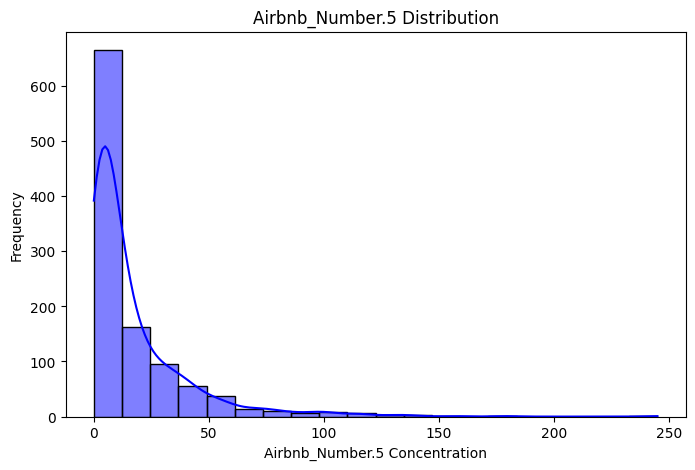

In [ ]:
# Airbnb Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Airbnb_Number'], bins=20, kde=True, color='blue')
plt.title("Airbnb_Number Distribution")
plt.xlabel("Airbnb_Number Concentration")
plt.ylabel("Frequency")
plt.show()


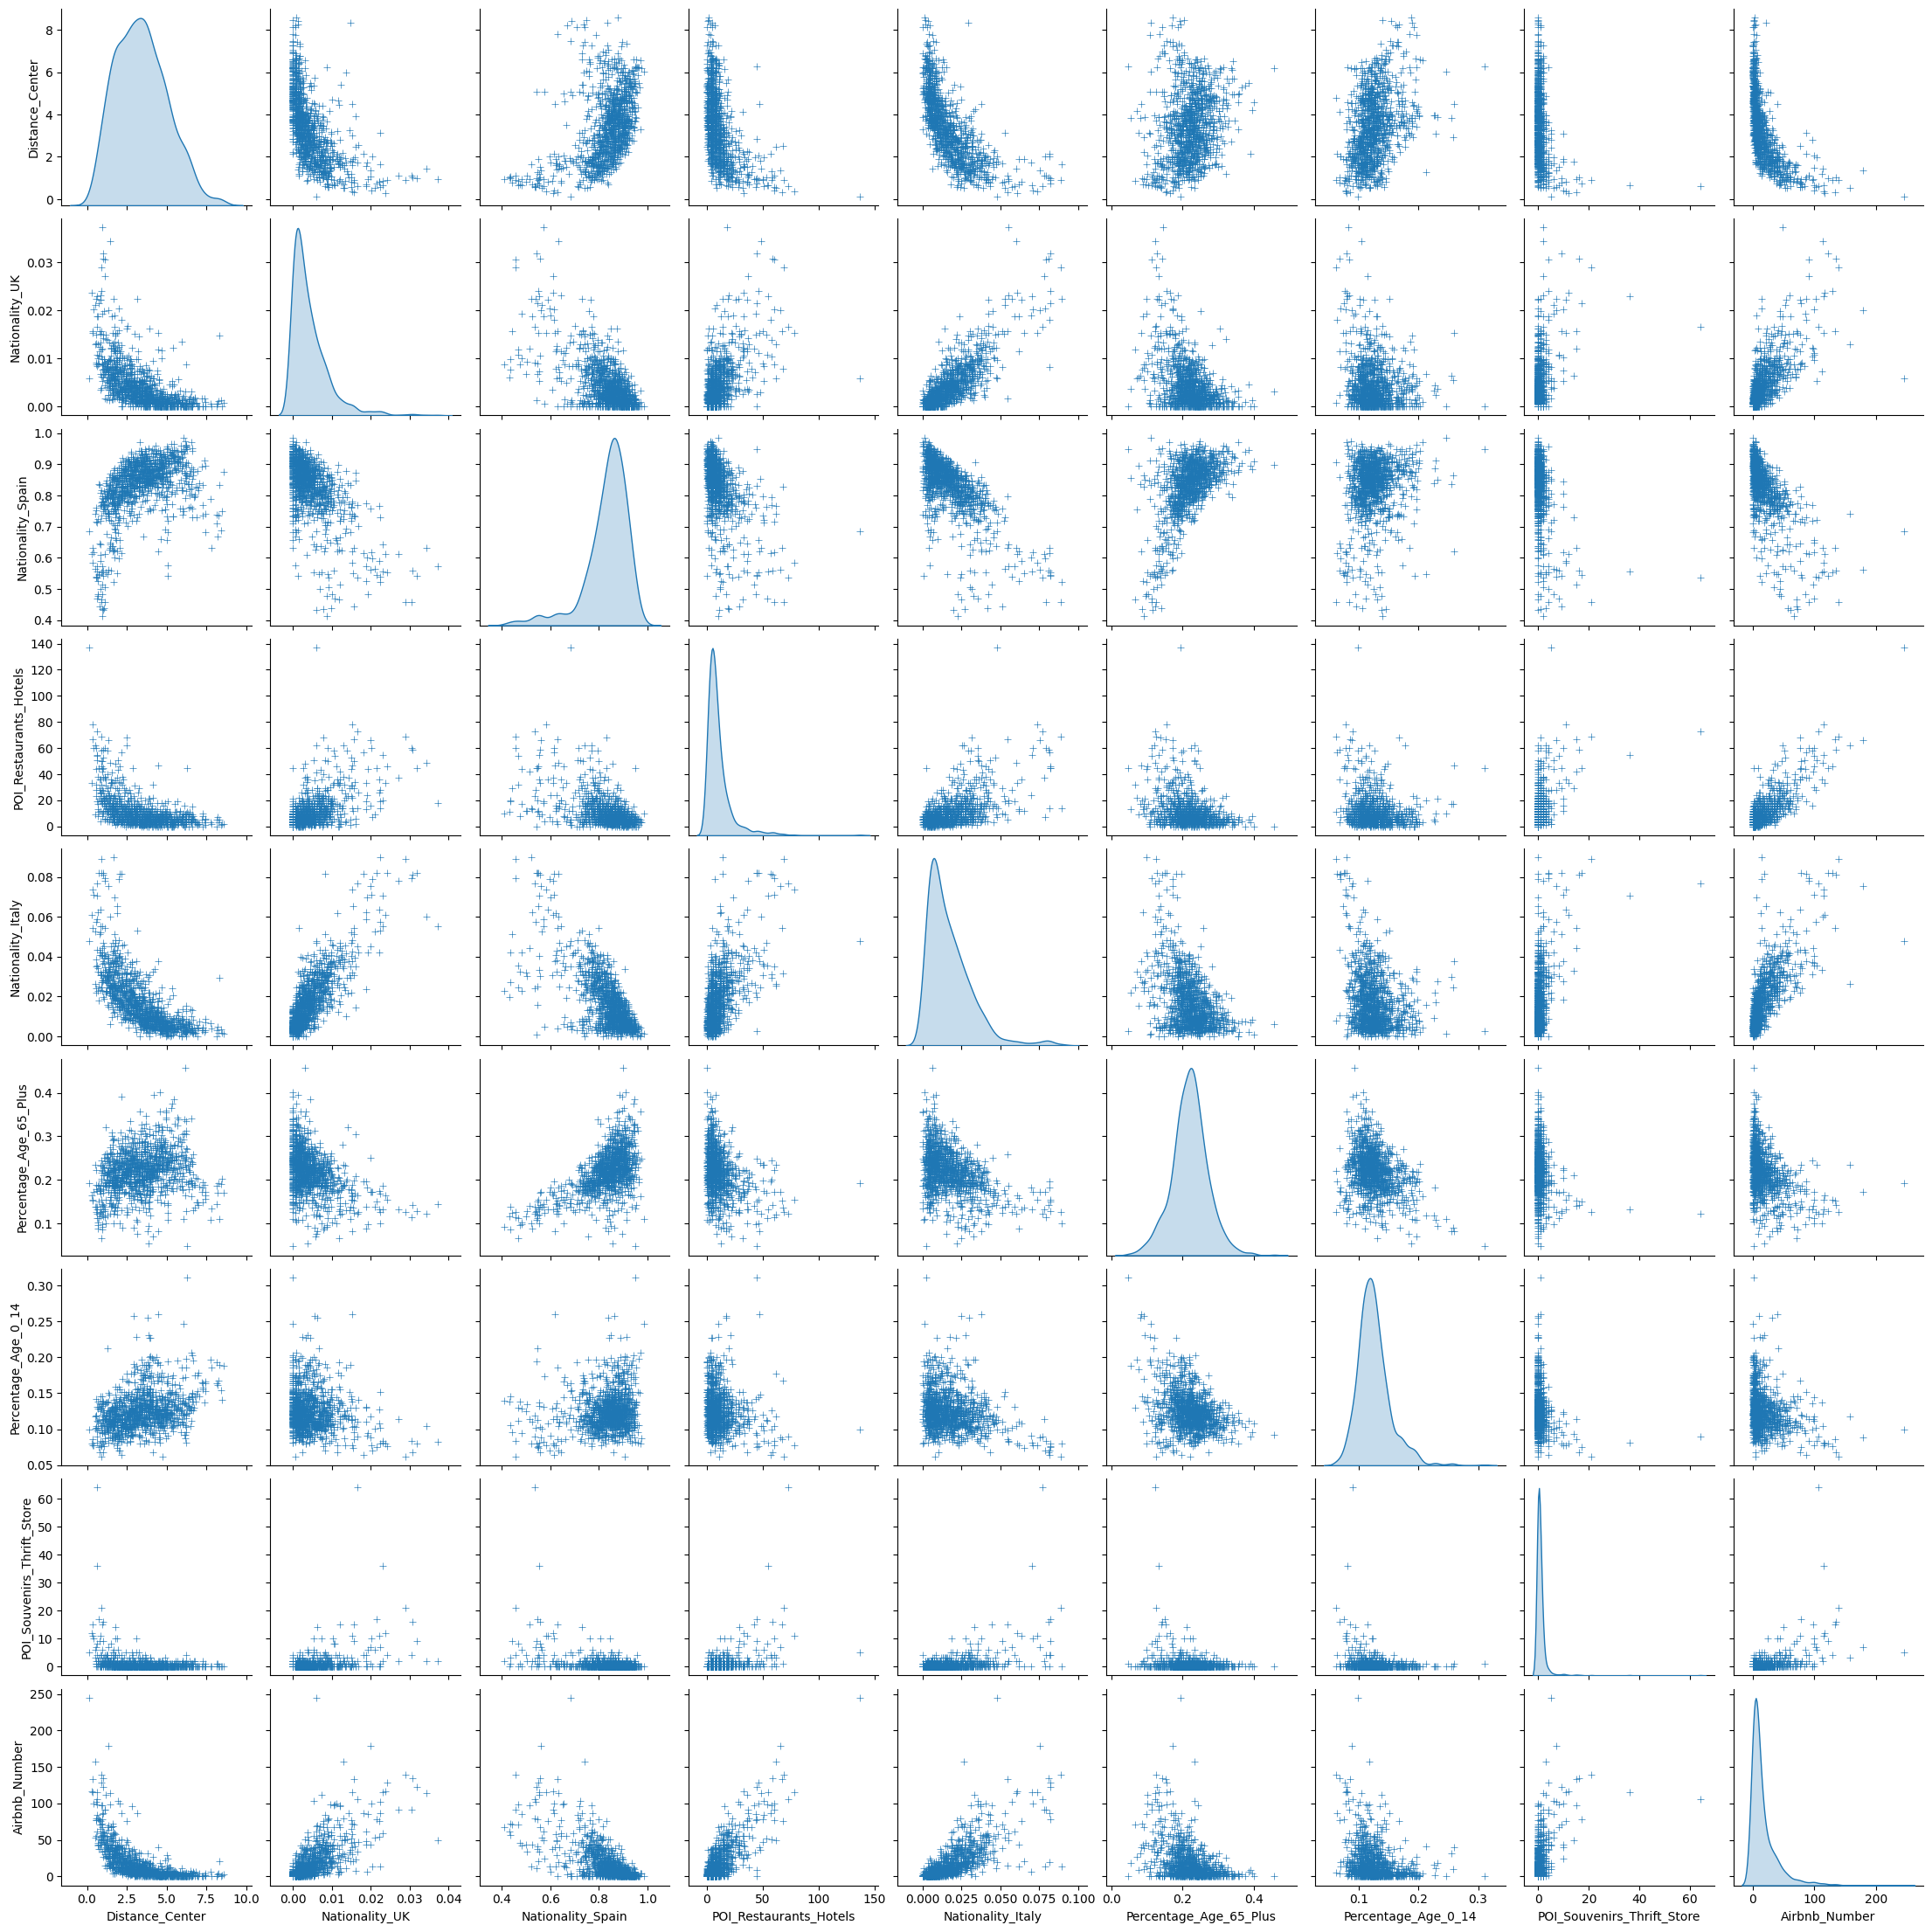

In [12]:
# Pairplot
variables = predictor_cols + [target_col]
sns.pairplot(df, vars= variables, diag_kind='kde', markers='+')
plt.show()

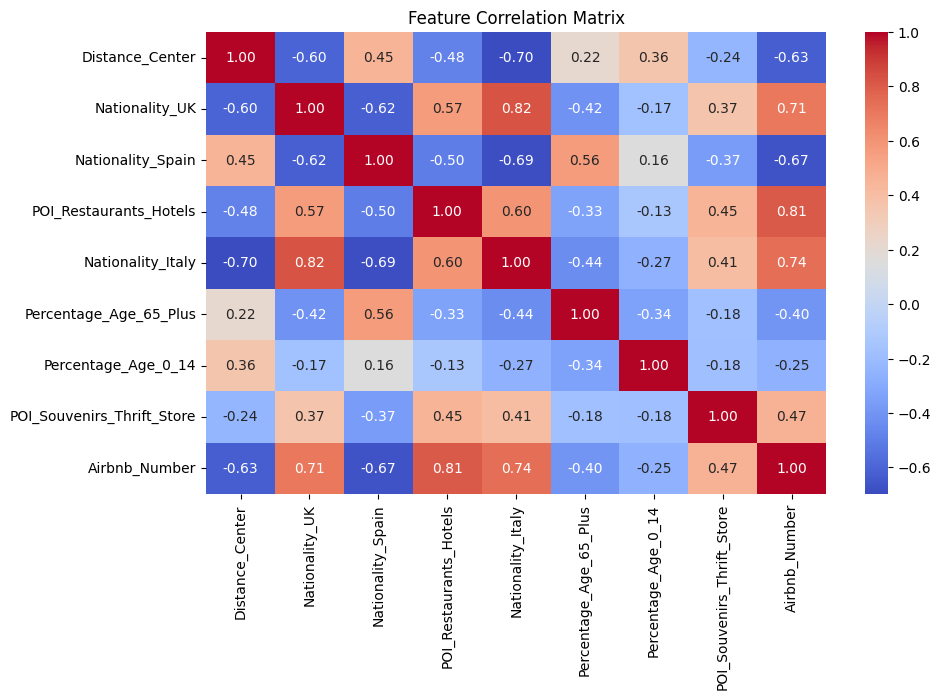

In [13]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[variables].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [14]:
correlation_matrix = df.corr().abs()
display(correlation_matrix['Airbnb_Number'].sort_values(ascending=False))  # Rank by correlation strength

Airbnb_Number                 1.000000
POI_Restaurants_Hotels        0.807480
Nationality_Italy             0.735628
Nationality_UK                0.707475
Nationality_Spain             0.669637
Distance_Center               0.629421
POI_Souvenirs_Thrift_Store    0.467630
Y                             0.431697
Percentage_Age_65_Plus        0.403070
Percentage_Age_0_14           0.253608
X                             0.058165
Name: Airbnb_Number, dtype: float64

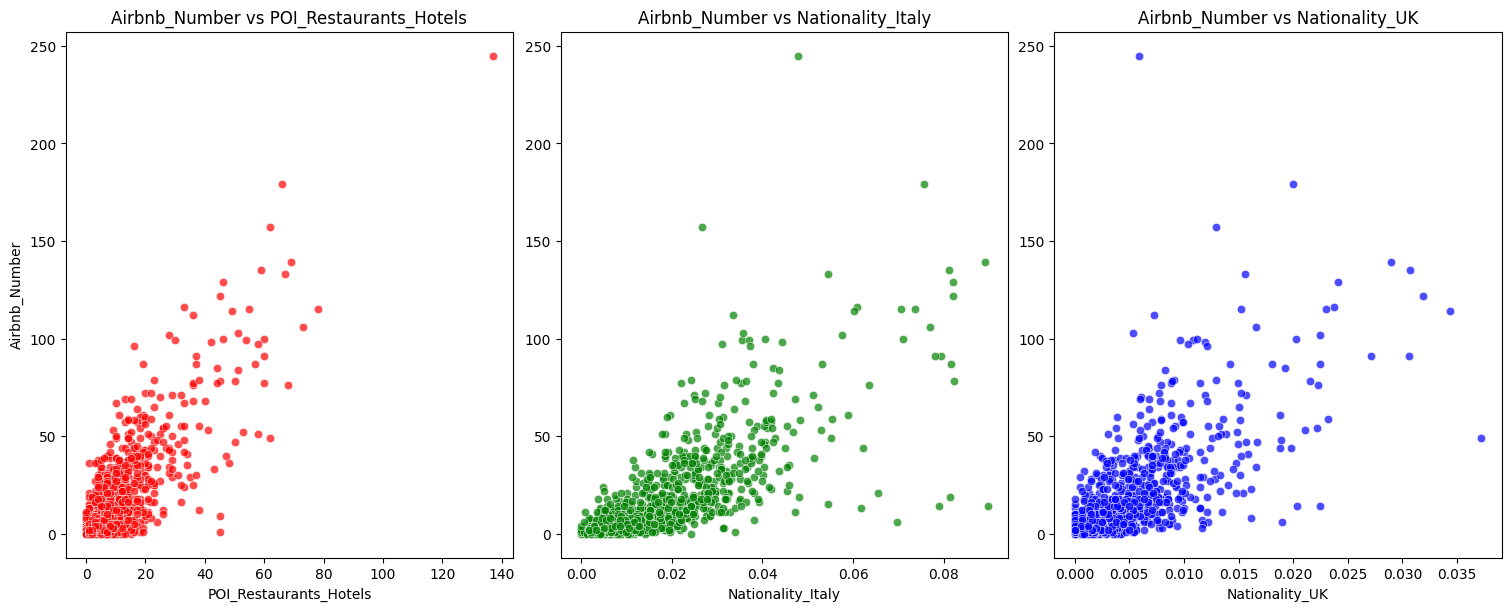

In [ ]:
# Scatter Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)

# Airbnb_Number vs POI_Restaurants_Hotels
sns.scatterplot(data=df, x='POI_Restaurants_Hotels', y='Airbnb_Number', ax=axes[0], color='red', alpha=0.7)
axes[0].set_title("Airbnb_Number vs POI_Restaurants_Hotels", fontsize=12)
axes[0].set_xlabel("POI_Restaurants_Hotels", fontsize=10)
axes[0].set_ylabel("Airbnb_Number", fontsize=10)

# Airbnb_Number vs Nationality_Italy
sns.scatterplot(data=df, x='Nationality_Italy', y='Airbnb_Number', ax=axes[1], color='green', alpha=0.7)
axes[1].set_title("Airbnb_Number vs Nationality_Italy", fontsize=12)
axes[1].set_xlabel("Nationality_Italy", fontsize=10)
axes[1].set_ylabel("", fontsize=10)

# Airbnb_Number vs Nationality_UK
sns.scatterplot(data=df, x='Nationality_UK', y='Airbnb_Number', ax=axes[2], color='blue', alpha=0.7)
axes[2].set_title("Airbnb_Number vs Nationality_UK", fontsize=12)
axes[2].set_xlabel("Nationality_UK", fontsize=10)
axes[2].set_ylabel("", fontsize=10)

# Adjust layout and show the plot
plt.show()

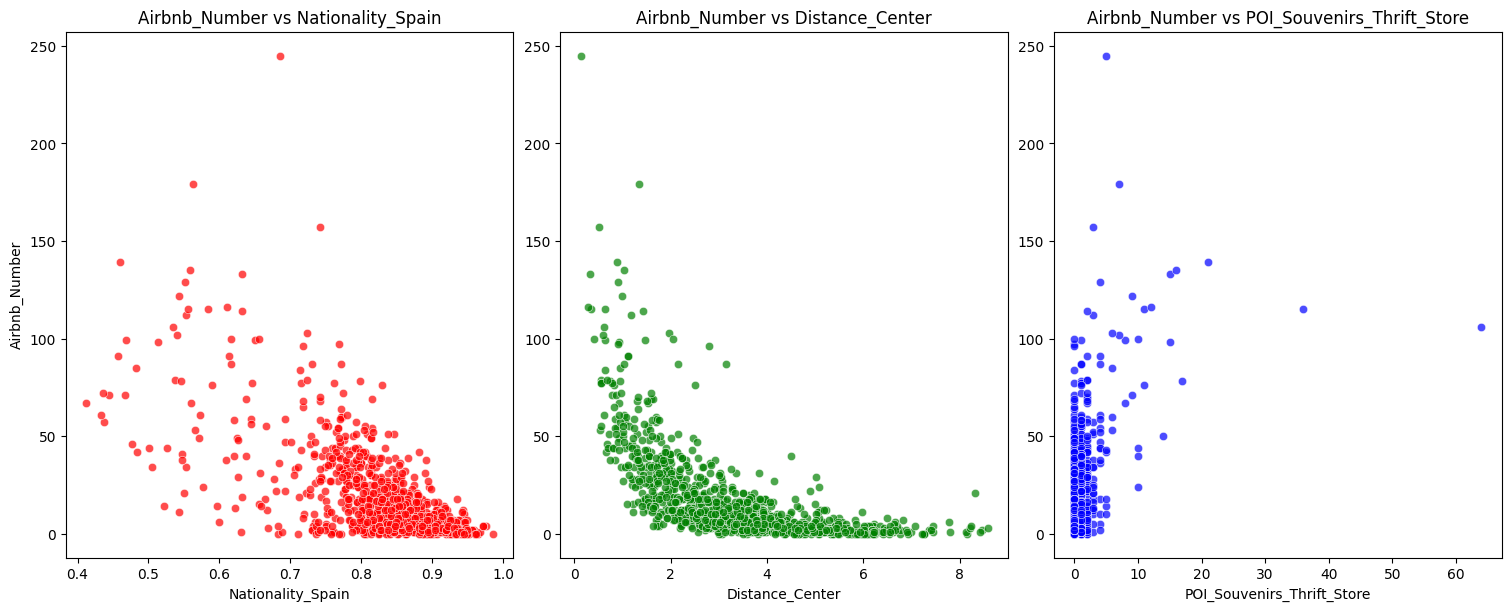

In [ ]:
# Scatter Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)

# Airbnb_Number vs Nationality_Spain
sns.scatterplot(data=df, x='Nationality_Spain', y='Airbnb_Number', ax=axes[0], color='red', alpha=0.7)
axes[0].set_title("Airbnb_Number vs Nationality_Spain", fontsize=12)
axes[0].set_xlabel("Nationality_Spain", fontsize=10)
axes[0].set_ylabel("Airbnb_Number", fontsize=10)

# Airbnb_Number vs Distance_Center
sns.scatterplot(data=df, x='Distance_Center', y='Airbnb_Number', ax=axes[1], color='green', alpha=0.7)
axes[1].set_title("Airbnb_Number vs Distance_Center", fontsize=12)
axes[1].set_xlabel("Distance_Center", fontsize=10)
axes[1].set_ylabel("", fontsize=10)

# Airbnb_Number vs POI_Souvenirs_Thrift_Store
sns.scatterplot(data=df, x='POI_Souvenirs_Thrift_Store', y='Airbnb_Number', ax=axes[2], color='blue', alpha=0.7)
axes[2].set_title("Airbnb_Number vs POI_Souvenirs_Thrift_Store", fontsize=12)
axes[2].set_xlabel("POI_Souvenirs_Thrift_Store", fontsize=10)
axes[2].set_ylabel("", fontsize=10)

# Adjust layout and show the plot
plt.show()

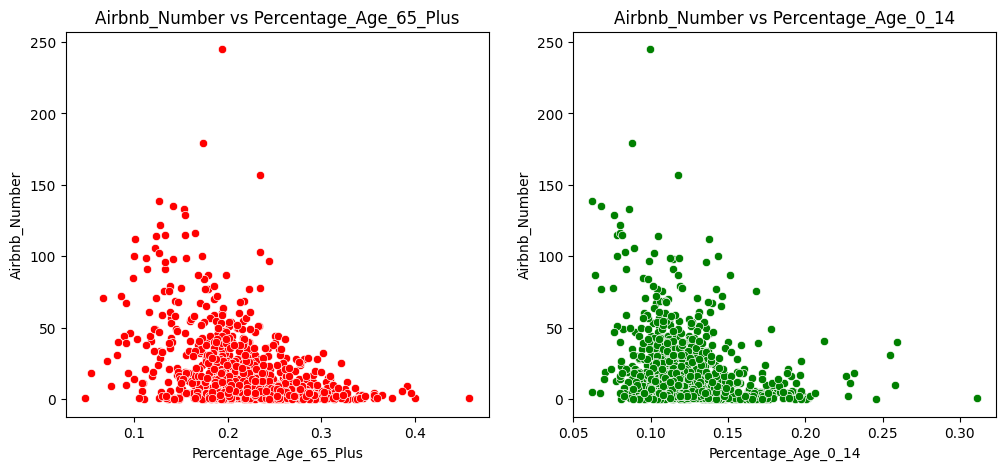

In [ ]:
# Scatter Plot: Age Percentages
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=df['Percentage_Age_65_Plus'], y=df['Airbnb_Number'], ax=axes[0], color='red')
axes[0].set_title("Airbnb_Number vs Percentage_Age_65_Plus")
sns.scatterplot(x=df['Percentage_Age_0_14'], y=df['Airbnb_Number'], ax=axes[1], color='green')
axes[1].set_title("Airbnb_Number vs Percentage_Age_0_14")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

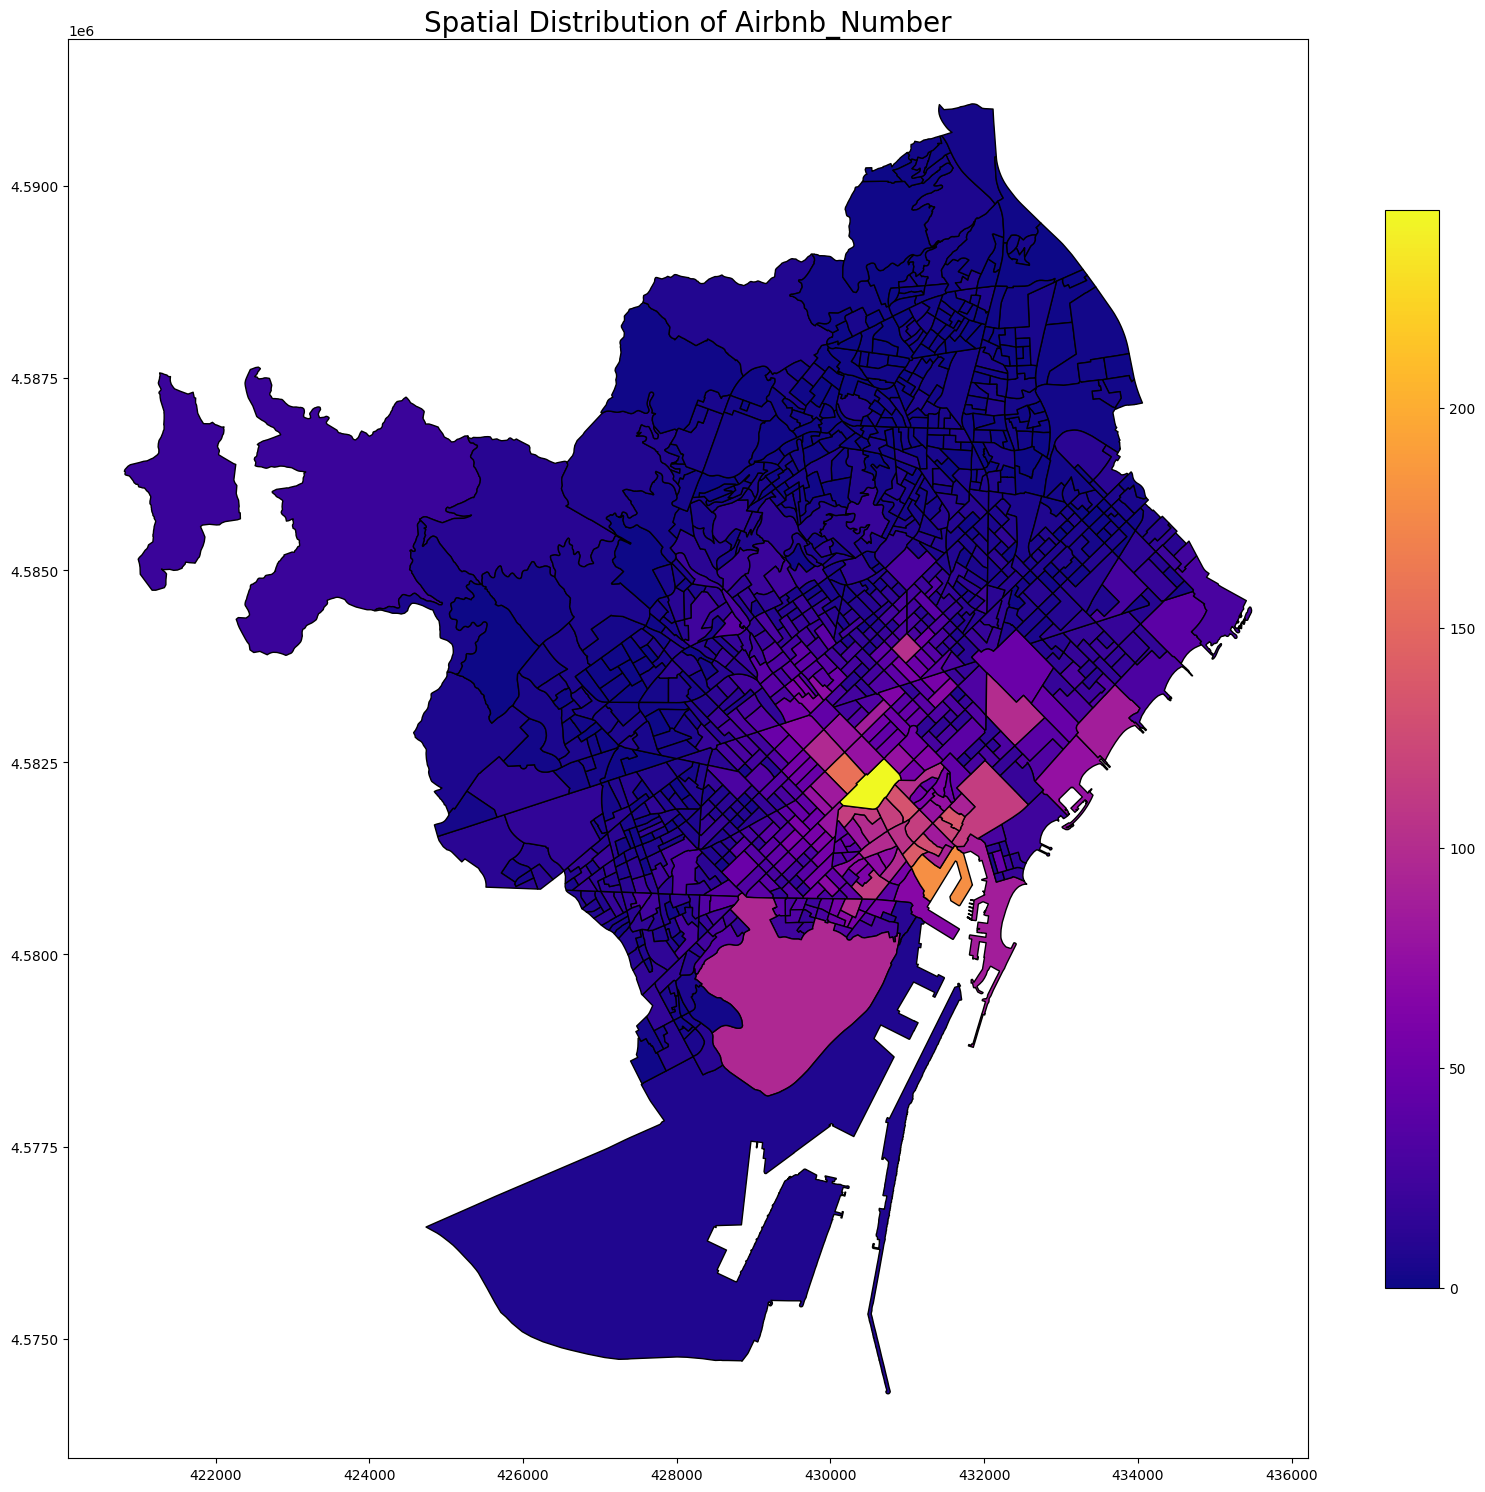

In [18]:
geo_info["Airbnb_Number"] = df["Airbnb_Number"]

# Plotting the spatial distribution of Airbnb_Number
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column='Airbnb_Number',
    cmap = 'plasma',
    edgecolor='black',
    legend=True,
    figsize=(20, 20),
    legend_kwds={'shrink': 0.7}
)

ax.set_title("Spatial Distribution of Airbnb_Number", fontsize=20)

plt.show

### Train/Test split

In [ ]:
# Define Features and Target
predictor_cols = ['Distance_Center', 'Nationality_UK', 'Nationality_Spain',
                    'POI_Restaurants_Hotels', 'Nationality_Italy', 'Percentage_Age_65_Plus',
                    'Percentage_Age_0_14', 'POI_Souvenirs_Thrift_Store'] 
target_col = 'Airbnb_Number'
coords_cols = ['X', 'Y']

# Split Data into Training and Testing Sets
train_data, test_data = train_test_split(df, test_size=0.15, random_state=118)

# Extract Values
X_train = train_data[predictor_cols].values
y_train = train_data[target_col].values.reshape(-1, 1)
coords_train = train_data[coords_cols].values

X_test = test_data[predictor_cols].values
y_test = test_data[target_col].values.reshape(-1, 1)
coords_test = test_data[coords_cols].values

# Standardize predictors for LR and SVR 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


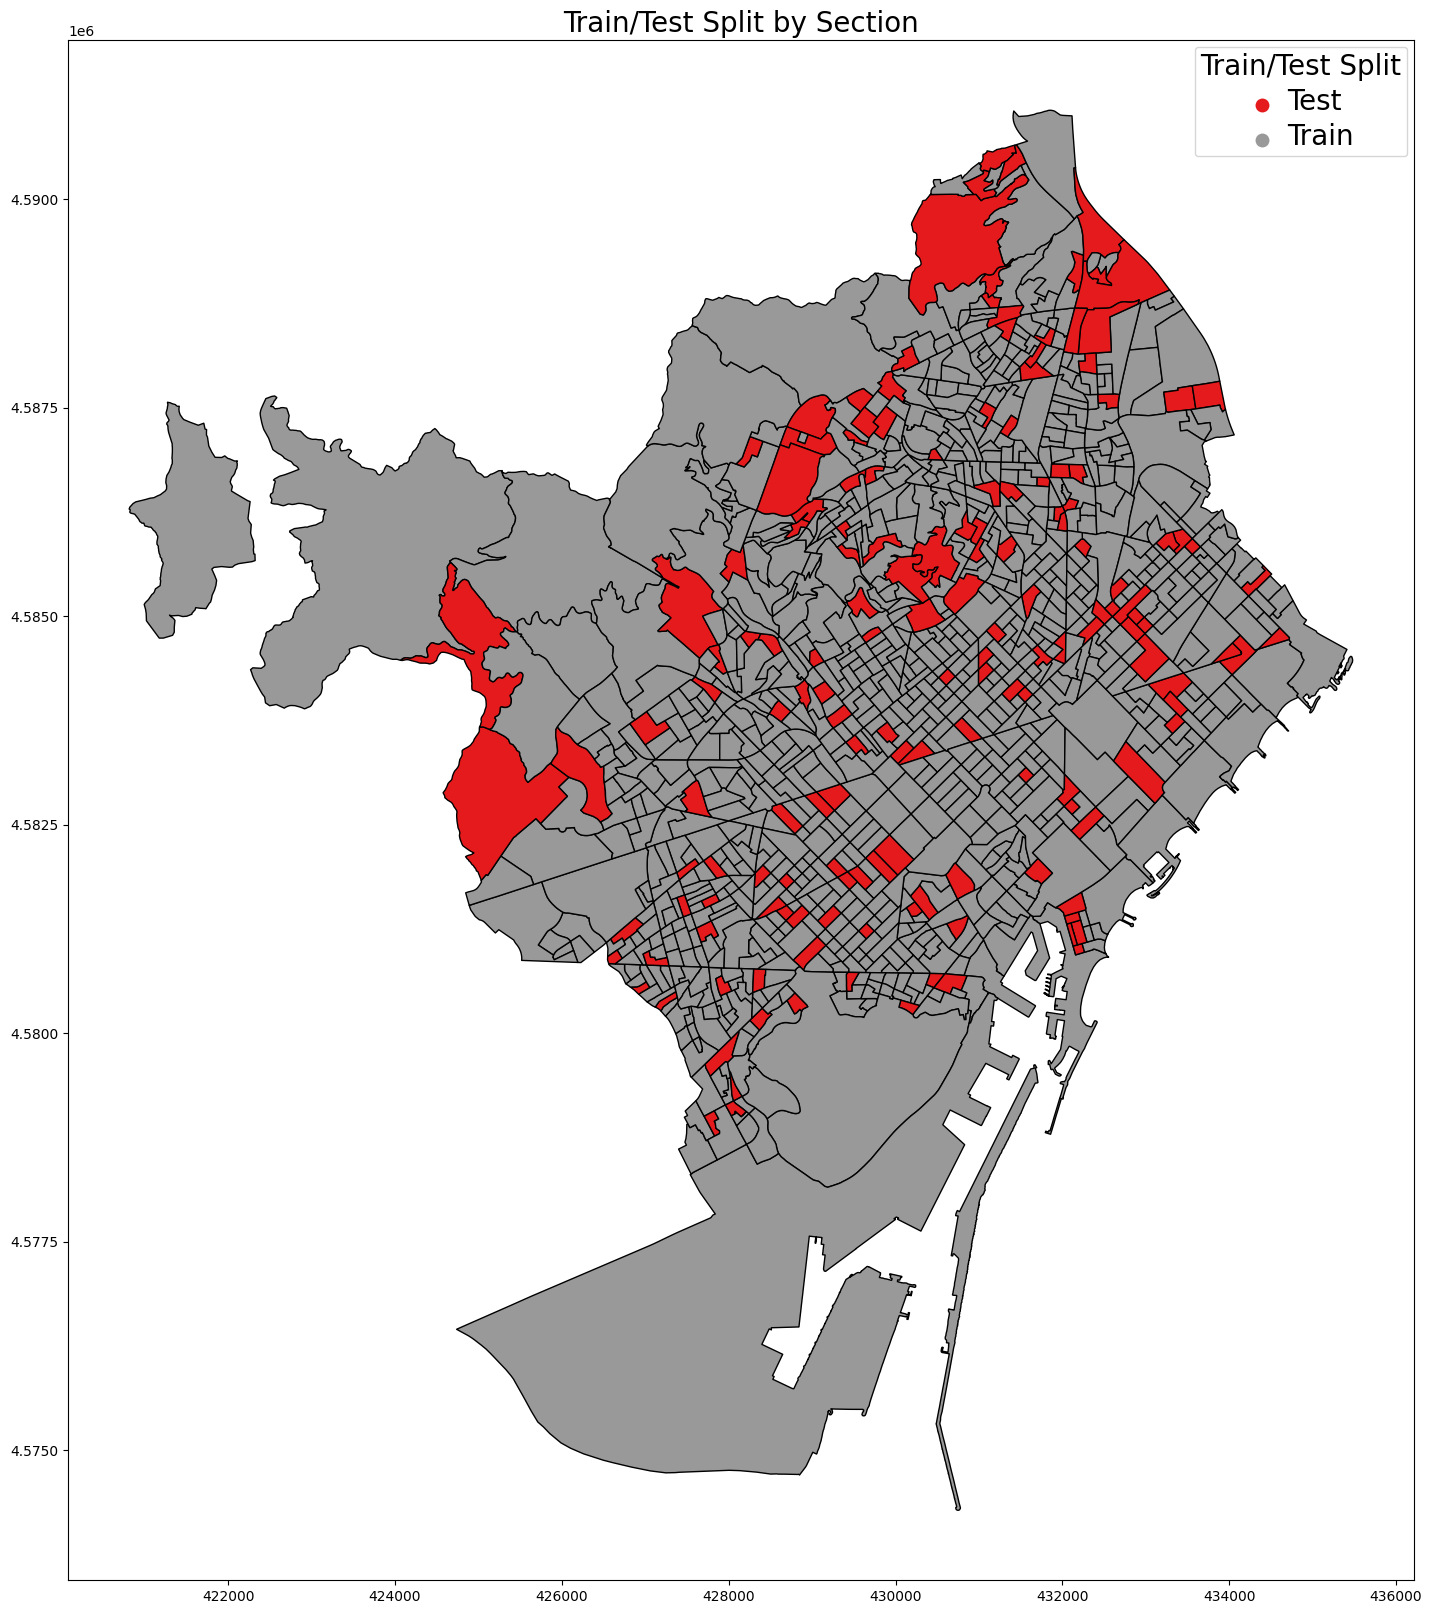

In [20]:
geo_info.loc[train_data.index, 'train'] = 'Train'
geo_info.loc[test_data.index, 'train'] = 'Test'

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    column='train',
    cmap='Set1',
    categorical=True,
    edgecolor='black',
    legend=True,
    figsize=(20, 20),
    legend_kwds={'loc': 'upper right', 'title': "Train/Test Split" }
)

leg = ax.get_legend()

for text in leg.get_texts():
    text.set_fontsize(20)  # Set the font size for legend text
leg.get_title().set_fontsize(20)  # Set the font size for legend title
ax.set_title("Train/Test Split by Section", fontsize=20)
plt.show()

In [21]:
def calculate_metrics(actual, predicted):
    # Avoid division by zero by adding a small constant if needed
    epsilon = 1e-10
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / (actual + epsilon)))

    # Mean Squared Error (MSE)
    mse = np.mean((actual - predicted) ** 2)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Normalized Mean Squared Error (NMSE)
    nmse = mse / np.var(actual)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual - predicted))

    # Relative Error Percent (REP)
    rep = (np.sum(np.abs(actual - predicted)) / (np.sum(actual) + epsilon))

    # R-squared (R² Score)
    r2 = r2_score(actual, predicted)

    # Pearson Correlation Coefficient
    pearson_corr = np.corrcoef(actual, predicted)[0, 1]

    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + epsilon))

    return {
        "MAPE": mape, 
        "NMSE": nmse, 
        "REP": rep, 
        "MSE": mse, 
        "RMSE": rmse, 
        "MAE": mae, 
        "R² Score": r2, 
        "Pearson Correlation": pearson_corr, 
        "SMAPE": smape
    }


## Linear Regression

In [22]:
# Linear Regression
lr_model = LinearRegression(fit_intercept=True)

t_start = time.time()

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
t_end = time.time()

lr_time = t_end - t_start

## SVR

In [23]:
# Create a list of parameter grids for different kernels.
param_grids = [
    # For RBF kernel
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.01, 0.1, 0.5]
    },
    # For linear kernel (gamma is not used, and poly-specific options are omitted)
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5]
    },
    # For polynomial kernel
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 1]
    },
    # For sigmoid kernel
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5],
        'gamma': ['scale', 'auto'],
        'coef0': [0, 1]
    }
]

# Combine the list into one combined parameter grid.
grid_search = GridSearchCV(
    SVR(),
    param_grid=param_grids,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-2
)

# Assuming X_train_scaled and y_train are properly defined  
time_start = time.time()
grid_search.fit(X_train_scaled, y_train.ravel())

# Extract the best estimator and parameters
best_svr = grid_search.best_estimator_

# Predict on the test set 
y_pred_svr = best_svr.predict(X_test_scaled)

time_end = time.time()
svr_time = time_end - time_start

print("Best SVR Parameters:", grid_search.best_params_)

Best SVR Parameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}


# Kernels

In [ ]:
# Define Kernel Functions
def gaussian_paper_kernel(distances, bandwidth):
    return np.exp(- (distances / bandwidth) ** 2)

def hybrid_gaussian_knn_kernel(distances, bandwidth, k_neighbors=5):
    sorted_indices = np.argsort(distances)
    weights = np.zeros_like(distances)
    weights[sorted_indices[:k_neighbors]] = 1  # Ensure at least k neighbors have weight
    gaussian_weights = np.exp(- (distances * 2) / ((bandwidth * 2)))
    return np.maximum(weights, gaussian_weights)

kernel_functions = {
    'paper_gaussian': gaussian_paper_kernel,
    'hybrid_gaussian_knn': hybrid_gaussian_knn_kernel
}


## Paper kernel

### GWR 

In [ ]:
# Initialize variables
intercept = True
kernel_name = 'paper_gaussian'
metric = 'euclidean'
n_max = 10  # Maximum number of neighbors to consider

kernel_func = kernel_functions[kernel_name]

# Precompute distance and median
distances_matrix = cdist(coords_test, coords_train, metric=metric)
medians = np.median(distances_matrix, axis=1)

# Precompute distance matrix for training data for cross-validation
train_distance_matrix = cdist(coords_train, coords_train, metric=metric)

n_test = len(coords_test)
n_train = len(y_train)


# Function to process each test point
def process_test_point(i):
    best_cv_i = float('inf')
    best_prediction_i = None
    best_bw_i = None
    distances_i = distances_matrix[i]
    median_i = medians[i]
    CV_i = {}

    for n in range(1, n_max + 1):
        bw_manual = max(0.05 * (n+1) * median_i, 1e-6)
        errors = np.empty(n_train)

        for j in range(n_train):
            mask = np.arange(n_train) != j
            X_train_e = X_train_scaled[mask]
            y_train_e = y_train[mask]

            distances = train_distance_matrix[j][mask]
            weights = kernel_func(distances, bw_manual)
            weights_sum = np.sum(weights)
            weights /= weights_sum if weights_sum != 0 else 1

            model = LinearRegression()
            model.fit(X_train_e, y_train_e, sample_weight=weights)
            y_pred = model.predict(X_train_scaled[j].reshape(1, -1))

            errors[j] = (y_train[j] - y_pred) ** 2

        cv = np.mean(errors)
        CV_i[(i, n)] = cv

        if cv < best_cv_i:
            best_cv_i = cv
            best_bw_i = bw_manual

            weights_vector = kernel_func(distances_i, best_bw_i)
            weights_sum = np.sum(weights_vector)
            weights_vector /= weights_sum if weights_sum != 0 else 1

            model = LinearRegression()
            model.fit(X_train_scaled, y_train, sample_weight=weights_vector)
            best_prediction_i = model.predict(X_test_scaled[i].reshape(1, -1))[0][0]

    return i, CV_i, best_bw_i, best_prediction_i

# Start the timer
time_start = time.time()

# Execute the processing in parallel
num_cores = multiprocessing.cpu_count()- 1
results = Parallel(n_jobs=num_cores)(
    delayed(process_test_point)(i) for i in range(n_test)
)

# Collect results
CV = {}
B = {}
predictions_dict = {}

for i, CV_i, best_bw_i, best_prediction_i in results:
    CV.update(CV_i)
    B[i] = best_bw_i
    predictions_dict[i] = best_prediction_i

time_end = time.time()
gwr_time_locv = time_end - time_start

# Select the best configuration for each test point
best_configs = {
    i: min({k: v for k, v in CV.items() if k[0] == i}, key=lambda k: CV[k])
    for i in range(n_test)
}

print("\nBest configurations obtained for each test point:")
for i, best_config in best_configs.items():
    print(f"Test Point {i}: n={best_config[1]}, bandwidth={B[i]:.2f}, CV Error={CV[best_config]:.2f}")

# Final predictions for each test point
y_pred_gwr_paper_locv = np.array([predictions_dict[i] for i in range(n_test)])



Best configurations obtained for each test point:
Test Point 0: n=4, bandwidth=1151.12, CV Error=90.10
Test Point 1: n=6, bandwidth=1157.86, CV Error=90.10
Test Point 2: n=3, bandwidth=1114.65, CV Error=90.15
Test Point 3: n=6, bandwidth=1224.11, CV Error=90.19
Test Point 4: n=6, bandwidth=1200.65, CV Error=90.14
Test Point 5: n=5, bandwidth=1171.30, CV Error=90.10
Test Point 6: n=4, bandwidth=1063.64, CV Error=90.35
Test Point 7: n=3, bandwidth=1123.73, CV Error=90.13
Test Point 8: n=5, bandwidth=1129.47, CV Error=90.12
Test Point 9: n=7, bandwidth=1206.32, CV Error=90.15
Test Point 10: n=4, bandwidth=1253.77, CV Error=90.29
Test Point 11: n=6, bandwidth=1152.68, CV Error=90.10
Test Point 12: n=5, bandwidth=1089.00, CV Error=90.23
Test Point 13: n=4, bandwidth=1064.50, CV Error=90.34
Test Point 14: n=5, bandwidth=1112.08, CV Error=90.16
Test Point 15: n=5, bandwidth=1079.16, CV Error=90.27
Test Point 16: n=6, bandwidth=1155.74, CV Error=90.10
Test Point 17: n=7, bandwidth=1164.77, CV

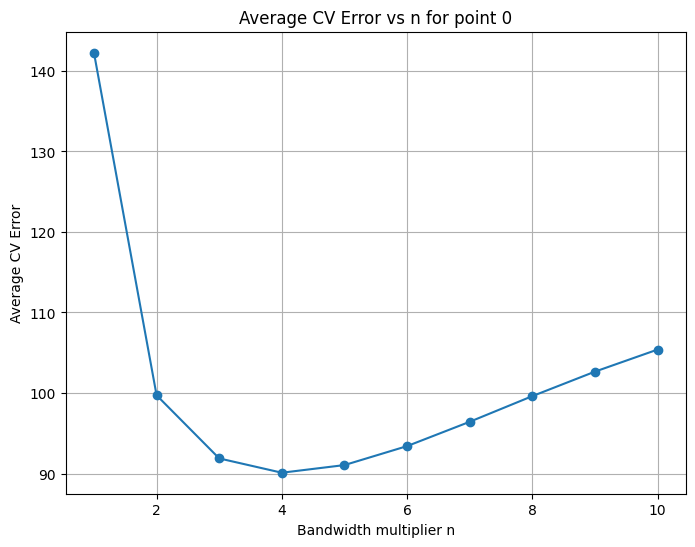

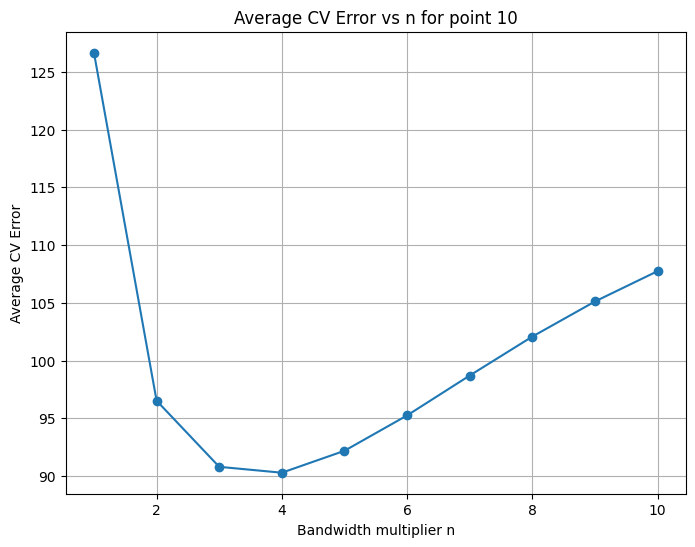

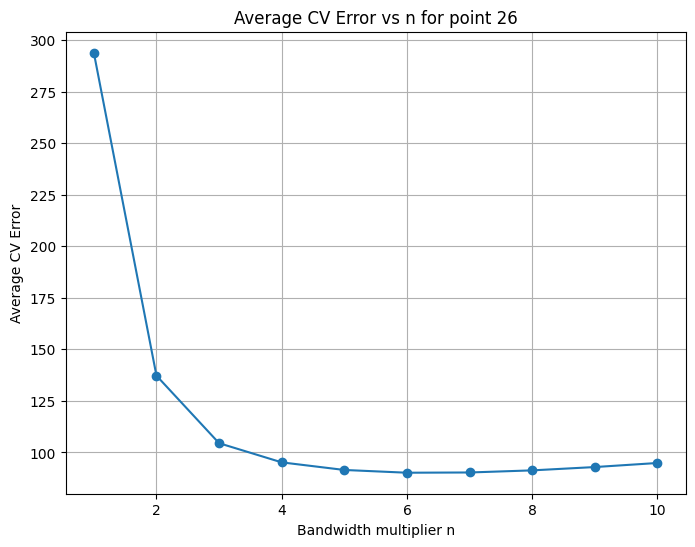

In [26]:
for i in [0,10,26]:

    cv_errors_by_n = []

    for n in range(1, n_max + 1):
        key = (i, n)
        if key in CV:
            cv_errors_by_n.append(CV[key])

    # Produce the plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1,n_max+1), cv_errors_by_n, marker='o')
    plt.xlabel('Bandwidth multiplier n')
    plt.ylabel('Average CV Error')
    plt.title(f'Average CV Error vs n for point {i}')
    plt.grid(True)
    plt.show()

### GWSVR

In [27]:
X_train_manual = X_train_scaled.copy()
X_test_manual = X_test_scaled.copy()

# Ensure targets are 1-dimensional
y_train = y_train.ravel()
y_test = y_test.ravel()

# Store results
CV = {}  # Stores Cross-validation errors
B = {}   # Stores bandwidths
predictions_dict = {}  # Stores best predictions
best_params = {}  # Stores best (C, gamma) values per test point

time_start = time.time()

# Compute distance matrix
distances_matrix = cdist(coords_test, coords_train, metric='euclidean')

# Select Kernel Function
kernel_func = gaussian_paper_kernel

# Define grid for hyperparameter tuning
C_values = [240,250,255,256,260,270]
epsilon_values = [0.1,0.01,1]
gamma_values = [0.002,0.003,0.004,0.005,'auto']

param_grid = {'C': C_values, 'gamma': gamma_values,'epsilon': epsilon_values}

# Maximum number of neighbors to consider
n_max = 10  

for i in tqdm(range(len(coords_test)), desc="Processing test points"):
    best_cv_i = float('inf')
    best_prediction_i = None
    best_bw_i = None
    best_C_i = None
    best_gamma_i = None
    best_n = None
    best_epsilon_i = None
    
    median_d = np.median(distances_matrix[i, :])
    for n in range(1, n_max + 1):
        bw_manual = max(0.05 * (n+1) * np.median(distances_matrix[i]), 1e-6) ##0.05
        # Compute weights using the chosen kernel function
        W = kernel_func(distances_matrix[i], bw_manual)
        W = W / np.sum(W)  # Normalize weights
        
        # Train SVR with GridSearchCV for hyperparameter tuning on the weighted training data.
        svr = SVR(kernel='rbf')
        grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-2, verbose=0)
        grid_search.fit(X_train_manual, y_train, sample_weight=W)
        
        # Get the cross-validation error (note: best_score_ is negative, so we take its negative)
        cv_candidate = -grid_search.best_score_
        
        # Get best hyperparameters for this candidate
        best_C = grid_search.best_params_['C']
        best_gamma = grid_search.best_params_['gamma']
        best_epsilon = grid_search.best_params_['epsilon']
        
        # If this candidate yields lower CV error, update the best configuration
        if cv_candidate < best_cv_i:
            best_cv_i = cv_candidate
            best_C_i = best_C
            best_gamma_i = best_gamma
            best_bw_i = bw_manual
            best_n = n
            best_epsilon_i = best_epsilon
            
            # Train the final model on the weighted training set using these best parameters
            svr_final = SVR(kernel='rbf', C=best_C, gamma=best_gamma, epsilon=best_epsilon)
            svr_final.fit(X_train_manual, y_train, sample_weight=W)
            y_pred = svr_final.predict(X_test_manual[i].reshape(1, -1))
            best_prediction_i = y_pred[0]

    # Store best values for test point i
    B[i] = best_bw_i
    predictions_dict[i] = best_prediction_i
    best_params[i] = (best_C_i, best_gamma_i, best_n, best_epsilon_i)
    CV[i] = best_cv_i
    
time_end = time.time()

gwr_time_gwsvr = time_end - time_start

print("\nBest configurations obtained for each test point:")
for i in range(len(coords_test)):
    print(f"Test Point {i}: bandwidth={B[i]:.2f}, n={best_params[i][2]}, CV Error={CV[i]:.2f}, C={best_params[i][0]}, gamma={best_params[i][1]}, epsilon={best_params[i][3]}")

# Final Predictions using Best Configuration
y_pred_gwsvr_paper = np.array([predictions_dict[i] for i in range(len(coords_test))])


Processing test points: 100%|██████████| 161/161 [32:00<00:00, 11.93s/it]


Best configurations obtained for each test point:
Test Point 0: bandwidth=2532.46, n=10, CV Error=497.51, C=270, gamma=auto, epsilon=1
Test Point 1: bandwidth=1819.49, n=10, CV Error=659.92, C=270, gamma=auto, epsilon=1
Test Point 2: bandwidth=3065.28, n=10, CV Error=705.33, C=270, gamma=auto, epsilon=1
Test Point 3: bandwidth=1923.60, n=10, CV Error=398.17, C=270, gamma=auto, epsilon=1
Test Point 4: bandwidth=1886.74, n=10, CV Error=385.82, C=270, gamma=auto, epsilon=1
Test Point 5: bandwidth=2147.39, n=10, CV Error=446.65, C=270, gamma=auto, epsilon=1
Test Point 6: bandwidth=2340.01, n=10, CV Error=415.07, C=270, gamma=auto, epsilon=1
Test Point 7: bandwidth=3090.27, n=10, CV Error=700.70, C=270, gamma=auto, epsilon=1
Test Point 8: bandwidth=2070.69, n=10, CV Error=412.38, C=270, gamma=auto, epsilon=0.01
Test Point 9: bandwidth=1658.70, n=10, CV Error=420.45, C=270, gamma=auto, epsilon=0.1
Test Point 10: bandwidth=2758.29, n=10, CV Error=446.10, C=270, gamma=auto, epsilon=1
Test Poi

In [28]:
# Compare the predictions
results_df = pd.DataFrame({
    'Actual': y_test.ravel(),
    'LR_Pred': y_pred_lr.ravel(),
    'SVR_Pred': y_pred_svr.ravel(),
    'GWR_Pred_gaussian': y_pred_gwr_paper_locv.ravel(),
    'GWSVR_Pred_gaussian': y_pred_gwsvr_paper.ravel()
})

In [29]:
# Add GWSVR Predictions to Metrics Calculation
models = ['LR_Pred', 'SVR_Pred', 'GWR_Pred_gaussian',  'GWSVR_Pred_gaussian']

metrics = {}

for model in models:
    col = f"{model}"
    met = calculate_metrics(results_df['Actual'], results_df[col])
    metrics[model] = met

# Print the metrics in a tabular format
metrics_df = pd.DataFrame(metrics).T

# Add times
metrics_df['Time (s)'] = [lr_time, svr_time, gwr_time_locv, gwr_time_gwsvr]
metrics_df['Time (s)'] = metrics_df['Time (s)'].round(2)
# Sort the metrics DataFrame by MAPE in ascending order and display
display(metrics_df.sort_values(by="MAE"))

MAPE      NMSE       REP        MSE      RMSE  \
GWR_Pred_gaussian    1.200191e+09  0.162709  0.327652  62.496666  7.905483   
GWSVR_Pred_gaussian  1.121775e+09  0.231835  0.380061  89.048085  9.436529   
SVR_Pred             1.726792e+09  0.232422  0.404775  89.273409  9.448461   
LR_Pred              2.157992e+09  0.250214  0.425209  96.107580  9.803447   

                          MAE  R² Score  Pearson Correlation     SMAPE  \
GWR_Pred_gaussian    4.751966  0.837291             0.919142  0.562768   
GWSVR_Pred_gaussian  5.512067  0.768165             0.896936  0.565921   
SVR_Pred             5.870494  0.767578             0.876178  0.759055   
LR_Pred              6.166846  0.749786             0.874256  0.847600   

                     Time (s)  
GWR_Pred_gaussian      222.86  
GWSVR_Pred_gaussian   1920.90  
SVR_Pred                15.93  
LR_Pred                  0.00

### Plot residuals

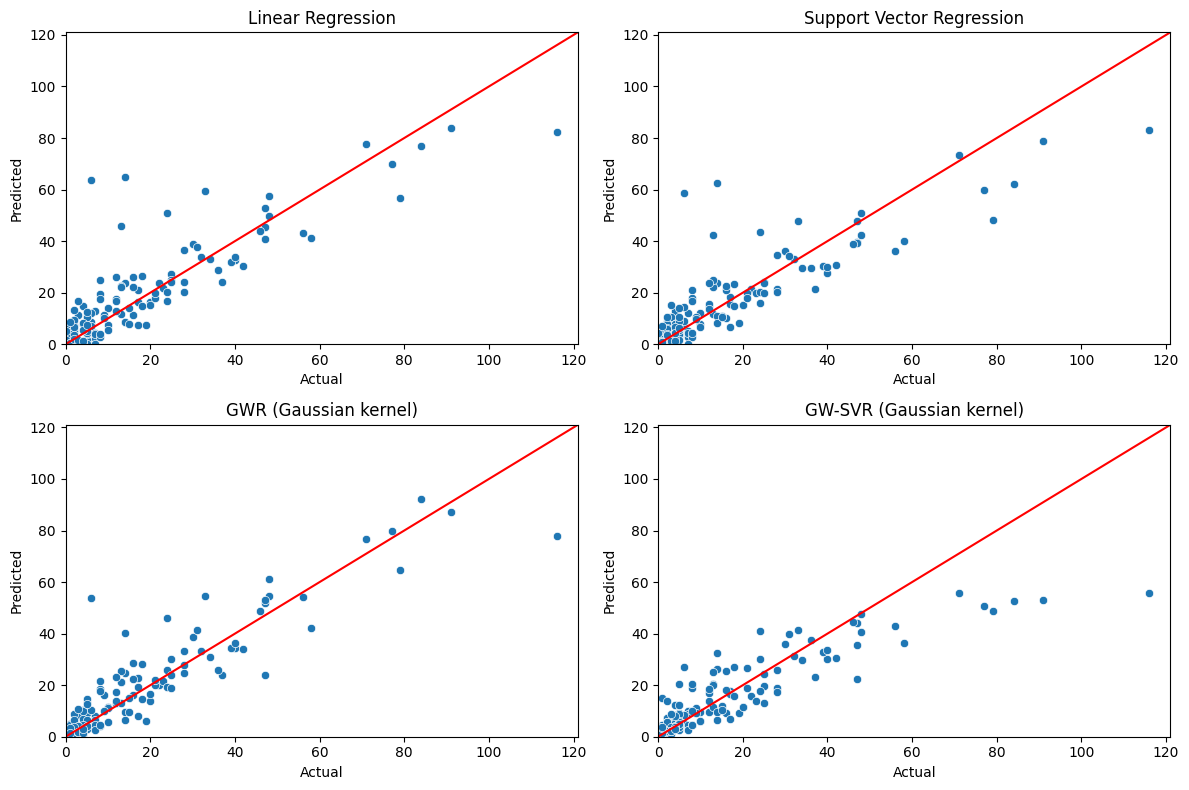

In [57]:
# Plot actual vs. predicted for each model
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x=results_df['Actual'], y=results_df['LR_Pred'])
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()+5],
         [results_df['Actual'].min(), results_df['Actual'].max()+5], color='red')
plt.xlim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.ylim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.title("Linear Regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 2)
sns.scatterplot(x=results_df['Actual'], y=results_df['SVR_Pred'])
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()+5],
         [results_df['Actual'].min(), results_df['Actual'].max()+5], color='red')
plt.xlim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.ylim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.title("Support Vector Regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 3)
sns.scatterplot(x=results_df['Actual'], y=results_df['GWR_Pred_gaussian'])
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()+5],
         [results_df['Actual'].min(), results_df['Actual'].max()+5], color='red')
plt.xlim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.ylim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.title("GWR (Gaussian kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 4)
sns.scatterplot(x=results_df['Actual'], y=results_df['GWSVR_Pred_gaussian'])
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()+5],
         [results_df['Actual'].min(), results_df['Actual'].max()+5], color='red')
plt.xlim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.ylim(results_df['Actual'].min(), results_df['Actual'].max()+5)
plt.title("GW-SVR (Gaussian kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


In [ ]:
# Prepare DataFrame for plotting
df_plot = pd.DataFrame({
    'X': coords_test[:, 0],
    'Y': coords_test[:, 1],
    'Airbnb_Number': y_test.ravel(),
    'y_pred_GWR': y_pred_gwr_paper_locv.ravel(),
    'y_pred_GWSVR': y_pred_gwsvr_paper.ravel()
})

# Calculate residuals 
df_plot["residuals_GWR"] = df_plot["Airbnb_Number"] - df_plot["y_pred_GWR"]
df_plot["residuals_GWSVR"] = df_plot["Airbnb_Number"] - df_plot["y_pred_GWSVR"]
# Absolute values of the residuals
df_plot["abs_residuals_GWR"] = df_plot["residuals_GWR"].abs()
df_plot["abs_residuals_GWSVR"] = df_plot["residuals_GWSVR"].abs()
# Relative residuals
df_plot["rel_residuals_GWR"] = df_plot["residuals_GWR"] / (df_plot["Airbnb_Number"] + 1e-10)
df_plot["rel_residuals_GWSVR"] = df_plot["residuals_GWSVR"] / (df_plot["Airbnb_Number"] + 1e-10)


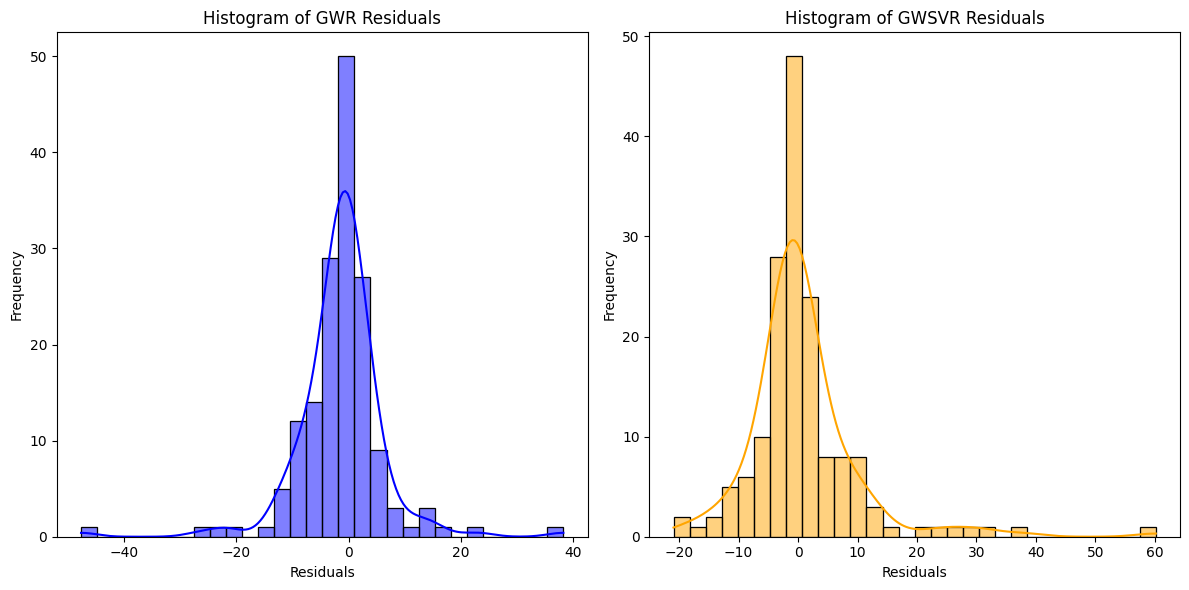

In [32]:
# Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_plot['residuals_GWR'], bins=30, kde=True, color='blue', label='GWR Residuals')
plt.title("Histogram of GWR Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
sns.histplot(df_plot['residuals_GWSVR'], bins=30, kde=True, color='orange', label='GWSVR Residuals')
plt.title("Histogram of GWSVR Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Add predictions and residuals to geo_info
geo_info['y_pred_GWR'] = np.nan
geo_info['residuals_GWR'] = np.nan
geo_info['abs_residuals_GWR'] = np.nan
geo_info['rel_residuals_GWR'] = np.nan
geo_info.loc[test_data.index, 'y_pred_GWR'] = df_plot['y_pred_GWR'].values
geo_info.loc[test_data.index, 'residuals_GWR'] = df_plot['residuals_GWR'].values
geo_info.loc[test_data.index, 'abs_residuals_GWR'] = df_plot['abs_residuals_GWR'].values
geo_info.loc[test_data.index, 'rel_residuals_GWR'] = df_plot['rel_residuals_GWR'].values

geo_info['y_pred_GWSVR'] = np.nan
geo_info['residuals_GWSVR'] = np.nan
geo_info['abs_residuals_GWSVR'] = np.nan
geo_info['rel_residuals_GWSVR'] = np.nan
geo_info.loc[test_data.index, 'y_pred_GWSVR'] = df_plot['y_pred_GWSVR'].values
geo_info.loc[test_data.index, 'residuals_GWSVR'] = df_plot['residuals_GWSVR'].values
geo_info.loc[test_data.index, 'abs_residuals_GWSVR'] = df_plot['abs_residuals_GWSVR'].values
geo_info.loc[test_data.index, 'rel_residuals_GWSVR'] = df_plot['rel_residuals_GWSVR'].values


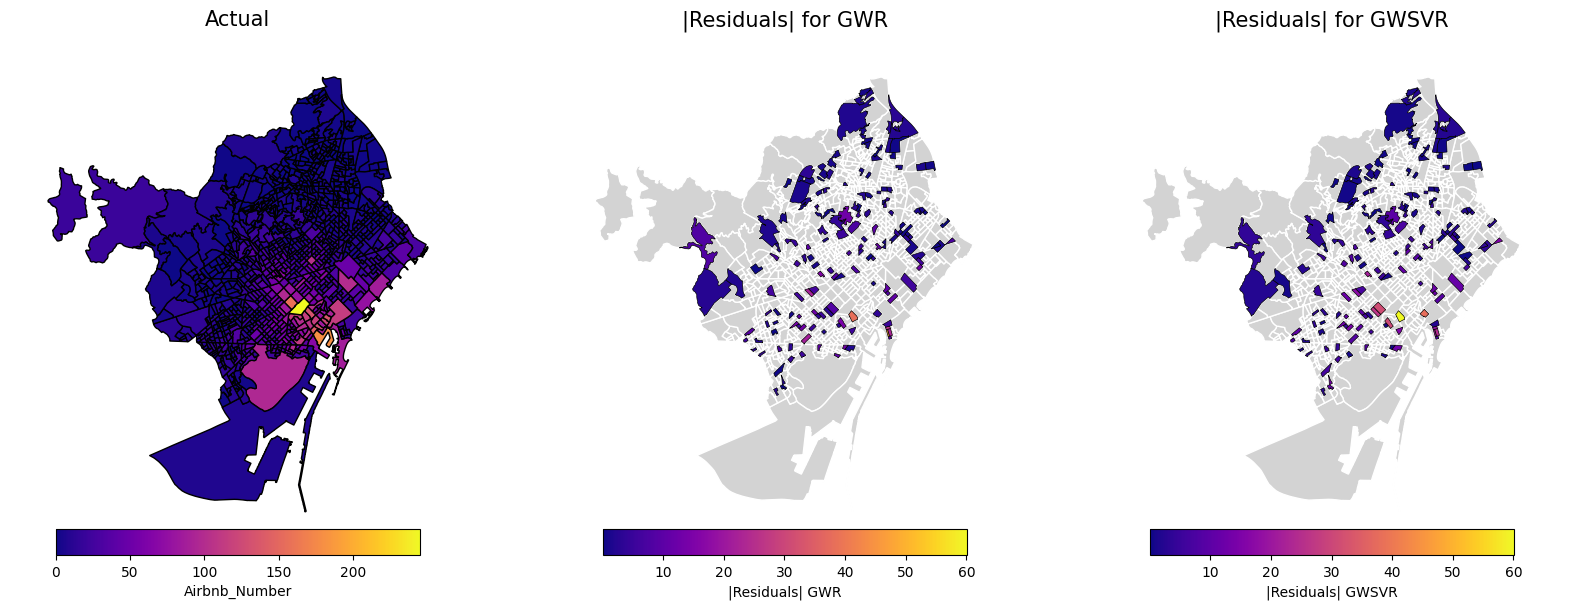

In [ ]:
# Plotting the results
is_test_gwr = geo_info['abs_residuals_GWR'].notna()
is_test_gwsvr = geo_info['abs_residuals_GWSVR'].notna()


fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# 1. Actual Airbnb Number
geo_info.plot(
    ax=ax[0],
    column='Airbnb_Number',
    cmap='plasma',
    edgecolor='black',
    legend=False
)
ax[0].set_title("Actual", fontsize=15)
ax[0].axis("off")

# Calculate common limits for residuals
res_min = min(geo_info['abs_residuals_GWR'].min(), geo_info['abs_residuals_GWSVR'].min())
res_max = max(geo_info['abs_residuals_GWR'].max(), geo_info['abs_residuals_GWSVR'].max())
xmin, xmax = geo_info.total_bounds[0], geo_info.total_bounds[2]
ymin, ymax = geo_info.total_bounds[1], geo_info.total_bounds[3]

# Zoom factor for all plots
zoom_factor = 0.1  # 10% extra margen
xrange = xmax - xmin
yrange = ymax - ymin
xmin_zoom = xmin - zoom_factor * xrange
xmax_zoom = xmax + zoom_factor * xrange
ymin_zoom = ymin - zoom_factor * yrange
ymax_zoom = ymax + zoom_factor * yrange

# 2. Absolute residuals GWR
geo_info.plot(ax=ax[1], color='lightgrey', edgecolor='white')
geo_info[is_test_gwr].plot(
    column="abs_residuals_GWR",
    cmap="plasma",
    legend=False,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[1].set_title("|Residuals| for GWR", fontsize=15)
ax[1].axis("off")
ax[1].set_xlim(xmin_zoom, xmax_zoom)
ax[1].set_ylim(ymin_zoom, ymax_zoom)

# 3. Absolute residuals GWSVR
geo_info.plot(ax=ax[2], color='lightgrey', edgecolor='white')
geo_info[is_test_gwsvr].plot(
    column="abs_residuals_GWSVR",
    cmap="plasma",
    legend=False,
    ax=ax[2],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[2].set_title("|Residuals| for GWSVR", fontsize=15)
ax[2].axis("off")
ax[2].set_xlim(xmin_zoom, xmax_zoom)
ax[2].set_ylim(ymin_zoom, ymax_zoom)

# Set common limits for all plots
ax[0].set_xlim(xmin_zoom, xmax_zoom)
ax[0].set_ylim(ymin_zoom, ymax_zoom)

# Add colorbars for each plot
for i, (sm, vmin, vmax, label) in enumerate([
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=geo_info['Airbnb_Number'].min(), vmax=geo_info['Airbnb_Number'].max())), geo_info['Airbnb_Number'].min(), geo_info['Airbnb_Number'].max(), "Airbnb_Number"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "|Residuals| GWR"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "|Residuals| GWSVR"),
]):
    sm._A = []
    cax = inset_axes(ax[i], width="80%", height="5%", loc='lower center', borderpad=0)
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label(label)

plt.show()


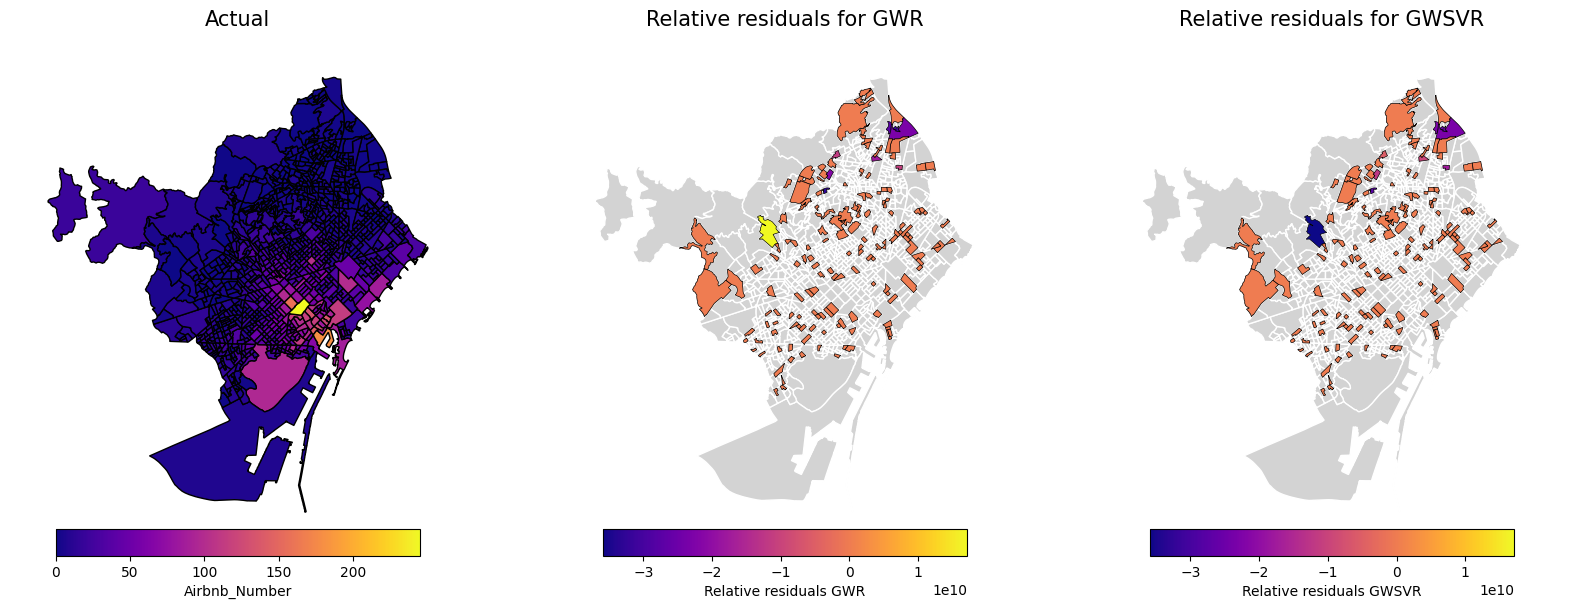

In [ ]:
# Plotting the relative residuals
is_test_gwr = geo_info['rel_residuals_GWR'].notna()
is_test_gwsvr = geo_info['rel_residuals_GWSVR'].notna()


fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# 1. Actual Airbnb Number
geo_info.plot(
    ax=ax[0],
    column='Airbnb_Number',
    cmap='plasma',
    edgecolor='black',
    legend=False
)
ax[0].set_title("Actual", fontsize=15)
ax[0].axis("off")

# Calculate common limits for relative residuals
res_min = min(geo_info['rel_residuals_GWR'].min(), geo_info['rel_residuals_GWSVR'].min())
res_max = max(geo_info['rel_residuals_GWR'].max(), geo_info['rel_residuals_GWSVR'].max())
xmin, xmax = geo_info.total_bounds[0], geo_info.total_bounds[2]
ymin, ymax = geo_info.total_bounds[1], geo_info.total_bounds[3]

# Zoom factor for all plots
zoom_factor = 0.1  # 10% extra margen
xrange = xmax - xmin
yrange = ymax - ymin
xmin_zoom = xmin - zoom_factor * xrange
xmax_zoom = xmax + zoom_factor * xrange
ymin_zoom = ymin - zoom_factor * yrange
ymax_zoom = ymax + zoom_factor * yrange

# 2. Relative residuals GWR
geo_info.plot(ax=ax[1], color='lightgrey', edgecolor='white')
geo_info[is_test_gwr].plot(
    column="rel_residuals_GWR",
    cmap="plasma",
    legend=False,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[1].set_title("Relative residuals for GWR", fontsize=15)
ax[1].axis("off")
ax[1].set_xlim(xmin_zoom, xmax_zoom)
ax[1].set_ylim(ymin_zoom, ymax_zoom)

# 3. Relative residuals GWSVR
geo_info.plot(ax=ax[2], color='lightgrey', edgecolor='white')
geo_info[is_test_gwsvr].plot(
    column="rel_residuals_GWSVR",
    cmap="plasma",
    legend=False,
    ax=ax[2],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[2].set_title("Relative residuals for GWSVR", fontsize=15)
ax[2].axis("off")
ax[2].set_xlim(xmin_zoom, xmax_zoom)
ax[2].set_ylim(ymin_zoom, ymax_zoom)

# Set common limits for all plots
ax[0].set_xlim(xmin_zoom, xmax_zoom)
ax[0].set_ylim(ymin_zoom, ymax_zoom)

# Add colorbars for each plot
for i, (sm, vmin, vmax, label) in enumerate([
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=geo_info['Airbnb_Number'].min(), vmax=geo_info['Airbnb_Number'].max())), geo_info['Airbnb_Number'].min(), geo_info['Airbnb_Number'].max(), "Airbnb_Number"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Relative residuals GWR"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Relative residuals GWSVR"),
]):
    sm._A = []
    cax = inset_axes(ax[i], width="80%", height="5%", loc='lower center', borderpad=0)
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label(label)

plt.show()


## New kernel, adjust k

### GWR

In [ ]:
# Initialize variables
intercept = True
kernel_name = 'hybrid_gaussian_knn'
metric = 'euclidean'
n_max = 10  # Maximum number of neighbors to consider

kernel_func = kernel_functions[kernel_name]

# Precompute distance and median
distances_matrix = cdist(coords_test, coords_train, metric=metric)
medians = np.median(distances_matrix, axis=1)

# Precompute distances between training points for CV
train_distance_matrix = cdist(coords_train, coords_train, metric=metric)

n_test = len(coords_test)
n_train = len(y_train)

# Function to process each test point
def process_test_point(i):
    best_cv_i = float('inf')
    best_prediction_i = None
    best_bw_i = None
    distances_i = distances_matrix[i]
    median_i = medians[i]
    best_k_i = None
    CV_i = {}

    # Iterate over the number of neighbors
    for k in range(1,5):

        for n in range(1, n_max + 1):
            bw_manual = max(0.01 * (n+9) * median_i, 1e-6) # 
            errors = np.empty(n_train)

            for j in range(n_train):
                mask = np.arange(n_train) != j
                X_train_e = X_train_scaled[mask]
                y_train_e = y_train[mask]

                distances = train_distance_matrix[j][mask]
                weights = kernel_func(distances, bw_manual, k_neighbors = k)
                weights_sum = np.sum(weights)
                weights /= weights_sum if weights_sum != 0 else 1

                model = LinearRegression()
                model.fit(X_train_e, y_train_e, sample_weight=weights)
                y_pred = model.predict(X_train_scaled[j].reshape(1, -1))

                errors[j] = (y_train[j] - y_pred) ** 2

            cv = np.mean(errors)
            CV_i[(i, n, k)] = cv

            if cv < best_cv_i:
                best_cv_i = cv
                best_bw_i = bw_manual
                best_k_i = k

                weights_vector = kernel_func(distances_i, best_bw_i, k_neighbors = best_k_i)
                weights_sum = np.sum(weights_vector)
                weights_vector /= weights_sum if weights_sum != 0 else 1

                model = LinearRegression()
                model.fit(X_train_scaled, y_train, sample_weight=weights_vector)
                best_prediction_i = model.predict(X_test_scaled[i].reshape(1, -1))[0]

    return i, CV_i, best_bw_i, best_prediction_i, best_k_i

# Measure time
time_start = time.time()

# Run in parallel
num_cores = multiprocessing.cpu_count()- 1
results = Parallel(n_jobs=num_cores)(
    delayed(process_test_point)(i) for i in range(n_test)
)

# Reconstruct results
CV = {}
B = {}
predictions_dict = {}
K = {}
for i, CV_i, best_bw_i, best_prediction_i, best_k_i in results:
    CV.update(CV_i)
    B[i] = best_bw_i
    predictions_dict[i] = best_prediction_i
    K[i] = best_k_i

time_end = time.time()
gwr_time_locv = time_end - time_start

# Select the best configuration
best_configs = {
    i: min({k: v for k, v in CV.items() if k[0] == i}, key=lambda k: CV[k])
    for i in range(n_test)
}

print("\nBest configurations obtained for each test point:")
for i, best_config in best_configs.items():
    print(f"Test Point {i}: n={best_config[1]}, bandwidth={B[i]:.2f}, k={K[i]}, CV Error={CV[best_config]:.2f}")

# Final predictions
y_pred_gwr_k_locv = np.array([predictions_dict[i] for i in range(n_test)])



Best configurations obtained for each test point:
Test Point 0: n=2, bandwidth=506.49, k=1, CV Error=88.50
Test Point 1: n=7, bandwidth=529.31, k=1, CV Error=88.47
Test Point 2: n=1, bandwidth=557.32, k=1, CV Error=88.53
Test Point 3: n=6, bandwidth=524.62, k=1, CV Error=88.47
Test Point 4: n=6, bandwidth=514.57, k=1, CV Error=88.48
Test Point 5: n=5, bandwidth=546.61, k=1, CV Error=88.49
Test Point 6: n=3, bandwidth=510.55, k=1, CV Error=88.49
Test Point 7: n=1, bandwidth=561.87, k=1, CV Error=88.55
Test Point 8: n=5, bandwidth=527.08, k=1, CV Error=88.47
Test Point 9: n=9, bandwidth=542.85, k=1, CV Error=88.48
Test Point 10: n=2, bandwidth=551.66, k=1, CV Error=88.51
Test Point 11: n=7, bandwidth=526.94, k=1, CV Error=88.47
Test Point 12: n=6, bandwidth=544.50, k=1, CV Error=88.49
Test Point 13: n=3, bandwidth=510.96, k=1, CV Error=88.49
Test Point 14: n=5, bandwidth=518.97, k=1, CV Error=88.47
Test Point 15: n=6, bandwidth=539.58, k=1, CV Error=88.48
Test Point 16: n=7, bandwidth=5

These plots are also created to show the evolution of the error according to the bandwidth n. The optimal bandwidth (n) seems to depend heavily on the chosen seed, so comparing with the plots from the paper is not very enlightening

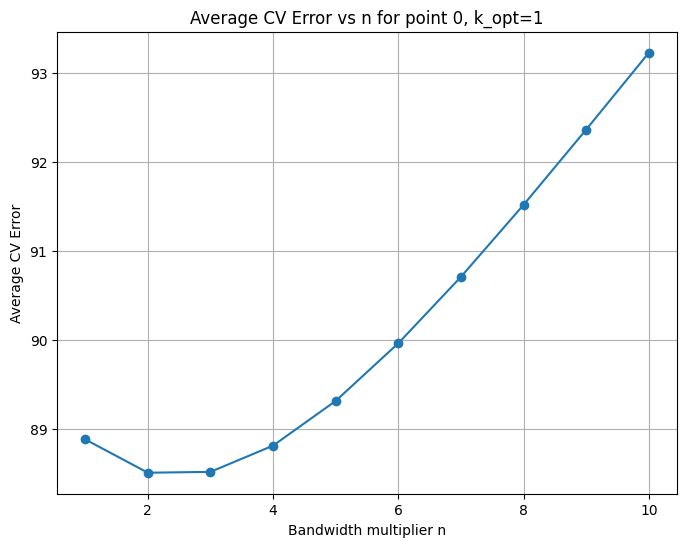

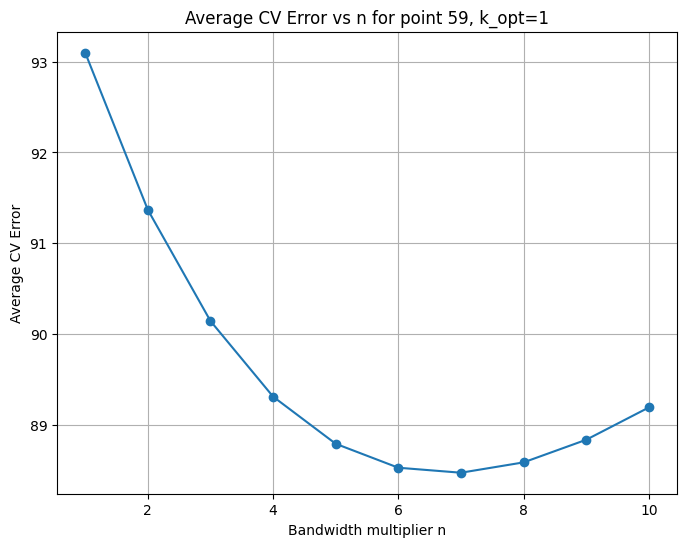

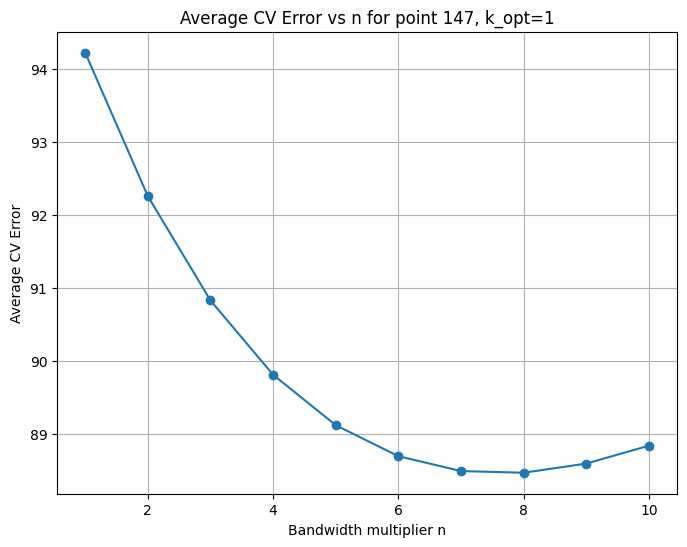

In [37]:
for i in [0, 59, 147]:
    k_opt = K[i]
    cv_errors_by_n = []
    for n in range(1, n_max + 1):
        key = (i, n, k_opt)
        if key in CV:
            cv_errors_by_n.append(CV[key])

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_max + 1), cv_errors_by_n, marker='o')
    plt.xlabel('Bandwidth multiplier n')
    plt.ylabel('Average CV Error')
    plt.title(f'Average CV Error vs n for point {i}, k_opt={k_opt}')
    plt.grid(True)
    plt.show()


### GWSVR

In [52]:
X_train_manual = X_train_scaled.copy()
X_test_manual = X_test_scaled.copy()

# Ensure targets are 1-dimensional
y_train = y_train.ravel()
y_test = y_test.ravel()

# Store results
CV = {}  # Stores Cross-validation errors
B = {}   # Stores bandwidths
predictions_dict = {}  # Stores best predictions
best_params = {}  # Stores best (C, gamma) values per test point

time_start = time.time()

# Compute distance matrix
distances_matrix = cdist(coords_test, coords_train, metric='euclidean')

# Select Kernel Function
kernel_func = hybrid_gaussian_knn_kernel

# Define grid for hyperparameter tuning
C_values = [240,250,255,256,260,270]
epsilon_values = [0.1,0.01,1]
gamma_values = [0.002,0.003,0.004,0.005,'auto']

param_grid = {'C': C_values, 'gamma': gamma_values,'epsilon': epsilon_values}

# Maximum number of neighbors to consider
n_max = 10  

for i in tqdm(range(len(coords_test)), desc="Processing test points"):
    best_cv_i = float('inf')
    best_prediction_i = None
    best_bw_i = None
    best_C_i = None
    best_gamma_i = None
    best_n = None
    best_epsilon_i = None
    
    median_d = np.median(distances_matrix[i, :])
    for n in range(1, n_max + 1):
        bw_manual = max(0.01 * (n+9) * np.median(distances_matrix[i]), 1e-6) ##0.05
        # Compute weights using the chosen kernel function
        W = kernel_func(distances_matrix[i], bw_manual,k_neighbors=K[i])
        W = W / np.sum(W)  # Normalize weights
        
        # Train SVR with GridSearchCV for hyperparameter tuning on the weighted training data.
        svr = SVR(kernel='rbf')
        grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-2, verbose=0)
        grid_search.fit(X_train_manual, y_train, sample_weight=W)
        
        # Get the cross-validation error (note: best_score_ is negative, so we take its negative)
        cv_candidate = -grid_search.best_score_
        
        # Get best hyperparameters for this candidate
        best_C = grid_search.best_params_['C']
        best_gamma = grid_search.best_params_['gamma']
        best_epsilon = grid_search.best_params_['epsilon']
        
        # If this candidate yields lower CV error, update the best configuration
        if cv_candidate < best_cv_i:
            best_cv_i = cv_candidate
            best_C_i = best_C
            best_gamma_i = best_gamma
            best_bw_i = bw_manual
            best_n = n
            best_epsilon_i = best_epsilon
            
            # Train the final model on the weighted training set using these best parameters
            svr_final = SVR(kernel='rbf', C=best_C, gamma=best_gamma, epsilon=best_epsilon)
            svr_final.fit(X_train_manual, y_train, sample_weight=W)
            y_pred = svr_final.predict(X_test_manual[i].reshape(1, -1))
            best_prediction_i = y_pred[0]

    # Store best values for test point i
    B[i] = best_bw_i
    predictions_dict[i] = best_prediction_i
    best_params[i] = (best_C_i, best_gamma_i, best_n, best_epsilon_i)
    CV[i] = best_cv_i
    
time_end = time.time()

gwr_time_gwsvr = time_end - time_start

print("\nBest configurations obtained for each test point:")
for i in range(len(coords_test)):
    print(f"Test Point {i}: bandwidth={B[i]:.2f}, n={best_params[i][2]}, CV Error={CV[i]:.2f}, C={best_params[i][0]}, gamma={best_params[i][1]}, epsilon={best_params[i][3]}")

# Final Predictions using Best Configuration
y_pred_gwsvr_k = np.array([predictions_dict[i] for i in range(len(coords_test))])


Processing test points: 100%|██████████| 161/161 [31:59<00:00, 11.92s/it]


Best configurations obtained for each test point:
Test Point 0: bandwidth=874.85, n=10, CV Error=506.51, C=270, gamma=auto, epsilon=0.01
Test Point 1: bandwidth=628.55, n=10, CV Error=695.63, C=270, gamma=auto, epsilon=1
Test Point 2: bandwidth=1058.91, n=10, CV Error=737.75, C=270, gamma=auto, epsilon=1
Test Point 3: bandwidth=664.52, n=10, CV Error=485.37, C=270, gamma=auto, epsilon=1
Test Point 4: bandwidth=651.78, n=10, CV Error=409.26, C=270, gamma=auto, epsilon=1
Test Point 5: bandwidth=741.83, n=10, CV Error=514.45, C=270, gamma=auto, epsilon=1
Test Point 6: bandwidth=808.37, n=10, CV Error=536.63, C=270, gamma=auto, epsilon=0.01
Test Point 7: bandwidth=1067.55, n=10, CV Error=730.80, C=270, gamma=auto, epsilon=1
Test Point 8: bandwidth=715.33, n=10, CV Error=540.45, C=270, gamma=auto, epsilon=1
Test Point 9: bandwidth=573.00, n=10, CV Error=476.79, C=270, gamma=auto, epsilon=1
Test Point 10: bandwidth=952.86, n=10, CV Error=517.09, C=270, gamma=auto, epsilon=1
Test Point 11: b

In [39]:
# Compare the predictions
results_df_k = pd.DataFrame({
    'Actual': y_test.ravel(),
    'LR_Pred': y_pred_lr.ravel(),
    'SVR_Pred': y_pred_svr.ravel(),
    'GWR_Pred_k_gaussian': y_pred_gwr_k_locv.ravel(),
    'GWSVR_Pred_k_gaussian': y_pred_gwsvr_k.ravel()
})

In [40]:
# Add GWSVR Predictions to Metrics Calculation
models = ['LR_Pred', 'SVR_Pred', 'GWR_Pred_k_gaussian',  'GWSVR_Pred_k_gaussian']

metrics_k = {}

for model in models:
    col = f"{model}"
    met = calculate_metrics(results_df_k['Actual'], results_df_k[col])
    metrics_k[model] = met

# Print the metrics in a tabular format
metrics_df_k = pd.DataFrame(metrics_k).T

# Add times
metrics_df_k['Time (s)'] = [lr_time, svr_time, gwr_time_locv, gwr_time_gwsvr]
metrics_df_k['Time (s)'] = metrics_df_k['Time (s)'].round(2)
# Sort the metrics DataFrame by MAPE in ascending order and display
display(metrics_df_k.sort_values(by="MAE"))

MAPE      NMSE       REP        MSE      RMSE  \
GWR_Pred_k_gaussian    1.029418e+09  0.156833  0.322067  60.239883  7.761436   
GWSVR_Pred_k_gaussian  9.731172e+08  0.221402  0.361421  85.040880  9.221761   
SVR_Pred               1.726792e+09  0.232422  0.404775  89.273409  9.448461   
LR_Pred                2.157992e+09  0.250214  0.425209  96.107580  9.803447   

                            MAE  R² Score  Pearson Correlation     SMAPE  \
GWR_Pred_k_gaussian    4.670968  0.843167             0.921202  0.581126   
GWSVR_Pred_k_gaussian  5.241734  0.778598             0.889235  0.545728   
SVR_Pred               5.870494  0.767578             0.876178  0.759055   
LR_Pred                6.166846  0.749786             0.874256  0.847600   

                       Time (s)  
GWR_Pred_k_gaussian     1065.96  
GWSVR_Pred_k_gaussian   1929.31  
SVR_Pred                  15.93  
LR_Pred                    0.00

### Plot residuals

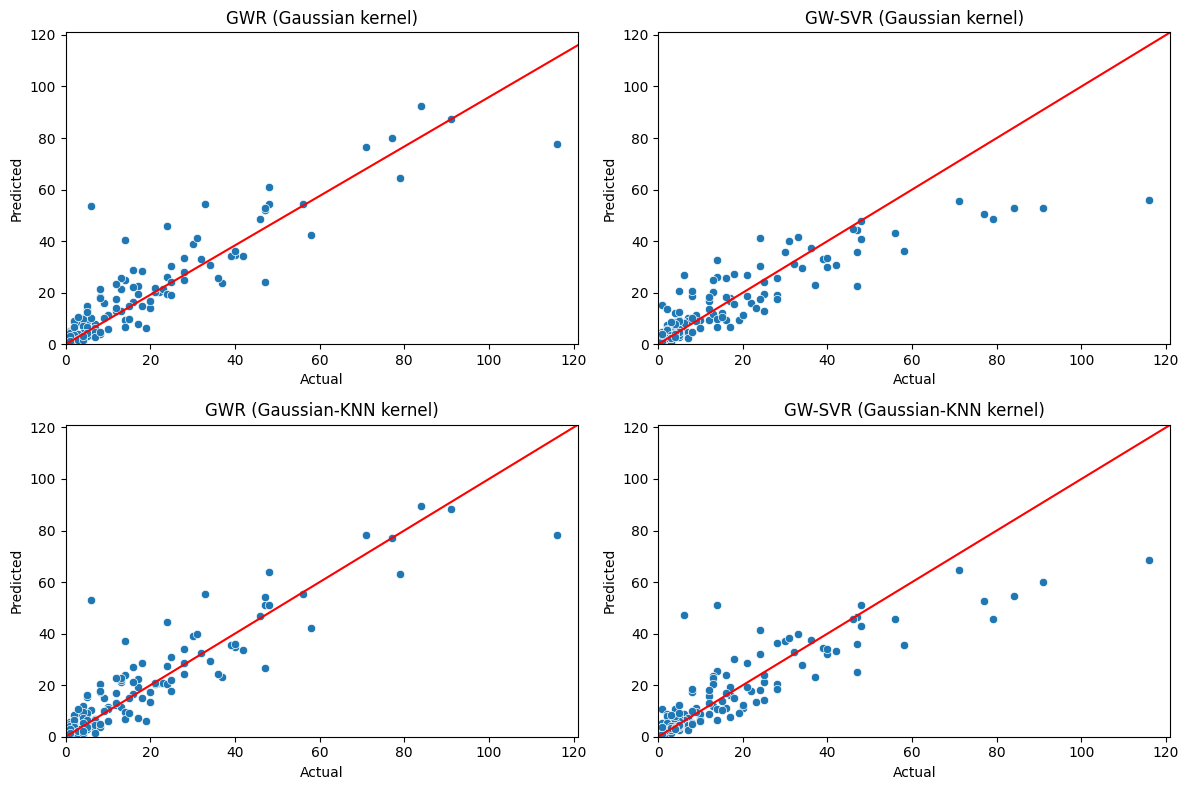

In [60]:
# Plot actual vs. predicted for each model
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x=results_df['Actual'], y=results_df['GWR_Pred_gaussian'])
plt.plot([results_df_k['Actual'].min(), results_df_k['Actual'].max()+5],
         [results_df_k['Actual'].min(), results_df_k['Actual'].max()], color='red')
plt.xlim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.ylim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.title("GWR (Gaussian kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 2)
sns.scatterplot(x=results_df['Actual'], y=results_df['GWSVR_Pred_gaussian'])
plt.plot([results_df_k['Actual'].min(), results_df_k['Actual'].max()+5],
         [results_df_k['Actual'].min(), results_df_k['Actual'].max()+5], color='red')
plt.xlim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.ylim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.title("GW-SVR (Gaussian kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 3)
sns.scatterplot(x=results_df_k['Actual'], y=results_df_k['GWR_Pred_k_gaussian'])
plt.plot([results_df_k['Actual'].min(), results_df_k['Actual'].max()+5],
         [results_df_k['Actual'].min(), results_df_k['Actual'].max()+5], color='red')
plt.xlim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.ylim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.title("GWR (Gaussian-KNN kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(2, 2, 4)
sns.scatterplot(x=results_df_k['Actual'], y=results_df_k['GWSVR_Pred_k_gaussian'])
plt.plot([results_df_k['Actual'].min(), results_df_k['Actual'].max()+5],
         [results_df_k['Actual'].min(), results_df_k['Actual'].max()+5], color='red')
plt.xlim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.ylim(results_df_k['Actual'].min(), results_df_k['Actual'].max()+5)
plt.title("GW-SVR (Gaussian-KNN kernel)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


In [ ]:
# Assuming y_pred is an array of predictions aligned with df
df_plot_k = pd.DataFrame({
    'X': coords_test[:, 0],
    'Y': coords_test[:, 1],
    'Airbnb_Number': y_test.ravel(),
    'y_pred_GWR_k': y_pred_gwr_k_locv.ravel(),
    'y_pred_GWSVR_k': y_pred_gwsvr_k.ravel()
})

# Calculate residuals
df_plot_k["residuals_GWR_k"] = df_plot_k["Airbnb_Number"] - df_plot_k["y_pred_GWR_k"]
df_plot_k["residuals_GWSVR_k"] = df_plot_k["Airbnb_Number"] - df_plot_k["y_pred_GWSVR_k"]
# Absolute values of residuals
df_plot_k["abs_residuals_GWR_k"] = df_plot_k["residuals_GWR_k"].abs()
df_plot_k["abs_residuals_GWSVR_k"] = df_plot_k["residuals_GWSVR_k"].abs()
# Relative values of residuals
df_plot_k["rel_residuals_GWR_k"] = df_plot_k["residuals_GWR_k"] / (df_plot_k["Airbnb_Number"] + 1e-10)
df_plot_k["rel_residuals_GWSVR_k"] = df_plot_k["residuals_GWSVR_k"] / (df_plot_k["Airbnb_Number"] + 1e-10)


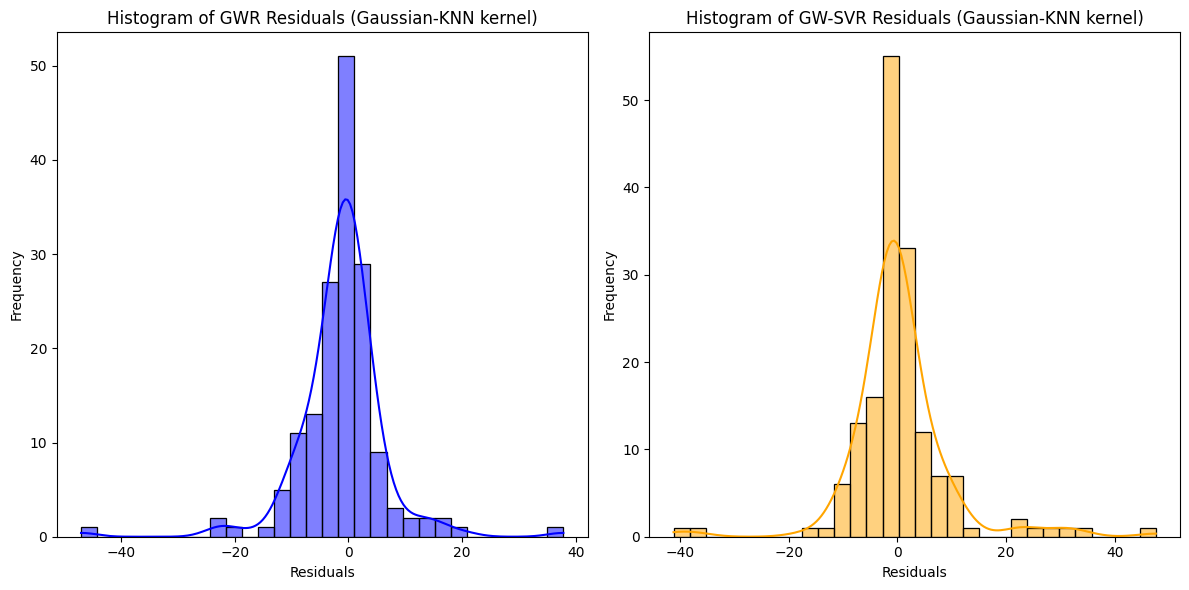

In [59]:
# Histogram of Residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_plot_k['residuals_GWR_k'], bins=30, kde=True, color='blue', label='GWR Residuals (KNN + Gaussian kernel)')
plt.title("Histogram of GWR Residuals (Gaussian-KNN kernel)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
sns.histplot(df_plot_k['residuals_GWSVR_k'], bins=30, kde=True, color='orange', label='GWSVR Residuals (KNN + Gaussian kernel)')
plt.title("Histogram of GW-SVR Residuals (Gaussian-KNN kernel)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Add predictions and residuals to geo_info
geo_info['y_pred_GWR_k'] = np.nan
geo_info['residuals_GWR_k'] = np.nan
geo_info['abs_residuals_GWR_k'] = np.nan
geo_info['rel_residuals_GWR_k'] = np.nan
geo_info.loc[test_data.index, 'y_pred_GWR_k'] = df_plot_k['y_pred_GWR_k'].values
geo_info.loc[test_data.index, 'residuals_GWR_k'] = df_plot_k['residuals_GWR_k'].values
geo_info.loc[test_data.index, 'abs_residuals_GWR_k'] = df_plot_k['abs_residuals_GWR_k'].values
geo_info.loc[test_data.index, 'rel_residuals_GWR_k'] = df_plot_k['rel_residuals_GWR_k'].values

geo_info['y_pred_GWSVR_k'] = np.nan
geo_info['residuals_GWSVR_k'] = np.nan
geo_info['abs_residuals_GWSVR_k'] = np.nan
geo_info['rel_residuals_GWSVR_k'] = np.nan
geo_info.loc[test_data.index, 'y_pred_GWSVR_k'] = df_plot_k['y_pred_GWSVR_k'].values
geo_info.loc[test_data.index, 'residuals_GWSVR_k'] = df_plot_k['residuals_GWSVR_k'].values
geo_info.loc[test_data.index, 'abs_residuals_GWSVR_k'] = df_plot_k['abs_residuals_GWSVR_k'].values
geo_info.loc[test_data.index, 'rel_residuals_GWSVR_k'] = df_plot_k['rel_residuals_GWSVR_k'].values


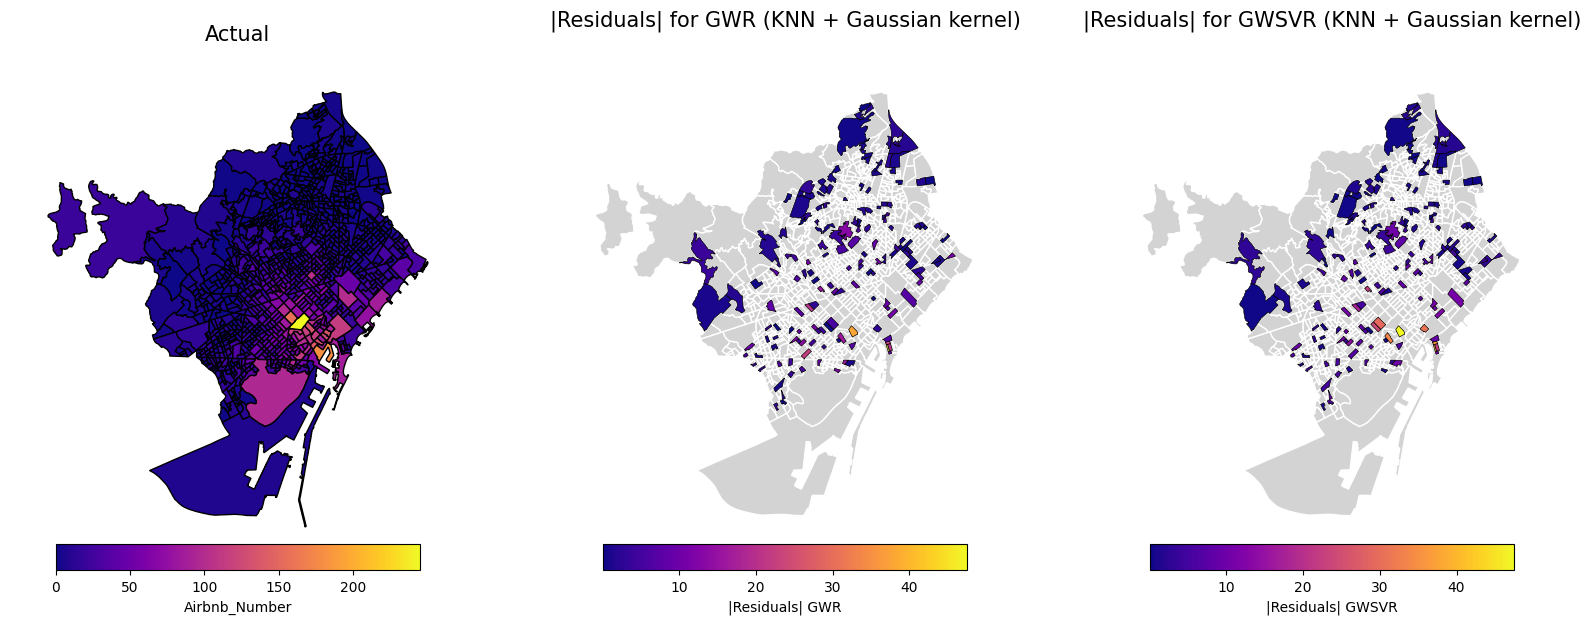

In [ ]:
# Plotting the results
is_test_gwr = geo_info['abs_residuals_GWR_k'].notna()
is_test_gwsvr = geo_info['abs_residuals_GWSVR_k'].notna()


fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# 1. Actual Airbnb Number
geo_info.plot(
    ax=ax[0],
    column='Airbnb_Number',
    cmap='plasma',
    edgecolor='black',
    legend=False
)
ax[0].set_title("Actual", fontsize=15)
ax[0].axis("off")

# Calculate common limits for residuals
res_min = min(geo_info['abs_residuals_GWR_k'].min(), geo_info['abs_residuals_GWSVR_k'].min())
res_max = max(geo_info['abs_residuals_GWR_k'].max(), geo_info['abs_residuals_GWSVR_k'].max())
xmin, xmax = geo_info.total_bounds[0], geo_info.total_bounds[2]
ymin, ymax = geo_info.total_bounds[1], geo_info.total_bounds[3]

# Zoom factor for all plots
zoom_factor = 0.1  # 10% extra margen
xrange = xmax - xmin
yrange = ymax - ymin
xmin_zoom = xmin - zoom_factor * xrange
xmax_zoom = xmax + zoom_factor * xrange
ymin_zoom = ymin - zoom_factor * yrange
ymax_zoom = ymax + zoom_factor * yrange

# 2. Absolutes residuals GWR (KNN + Gaussian kernel)
geo_info.plot(ax=ax[1], color='lightgrey', edgecolor='white')
geo_info[is_test_gwr].plot(
    column="abs_residuals_GWR_k",
    cmap="plasma",
    legend=False,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[1].set_title("|Residuals| for GWR (KNN + Gaussian kernel)", fontsize=15)
ax[1].axis("off")
ax[1].set_xlim(xmin_zoom, xmax_zoom)
ax[1].set_ylim(ymin_zoom, ymax_zoom)

# 3. Absolute residuals GWSVR (KNN + Gaussian kernel)
geo_info.plot(ax=ax[2], color='lightgrey', edgecolor='white')
geo_info[is_test_gwsvr].plot(
    column="abs_residuals_GWSVR_k",
    cmap="plasma",
    legend=False,
    ax=ax[2],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[2].set_title("|Residuals| for GWSVR (KNN + Gaussian kernel)", fontsize=15)
ax[2].axis("off")
ax[2].set_xlim(xmin_zoom, xmax_zoom)
ax[2].set_ylim(ymin_zoom, ymax_zoom)

# Set common limits for all plots
ax[0].set_xlim(xmin_zoom, xmax_zoom)
ax[0].set_ylim(ymin_zoom, ymax_zoom)

# Add colorbars for each plot
for i, (sm, vmin, vmax, label) in enumerate([
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=geo_info['Airbnb_Number'].min(), vmax=geo_info['Airbnb_Number'].max())), geo_info['Airbnb_Number'].min(), geo_info['Airbnb_Number'].max(), "Airbnb_Number"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "|Residuals| GWR"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "|Residuals| GWSVR"),
]):
    sm._A = []
    cax = inset_axes(ax[i], width="80%", height="5%", loc='lower center', borderpad=0)
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label(label)

plt.show()


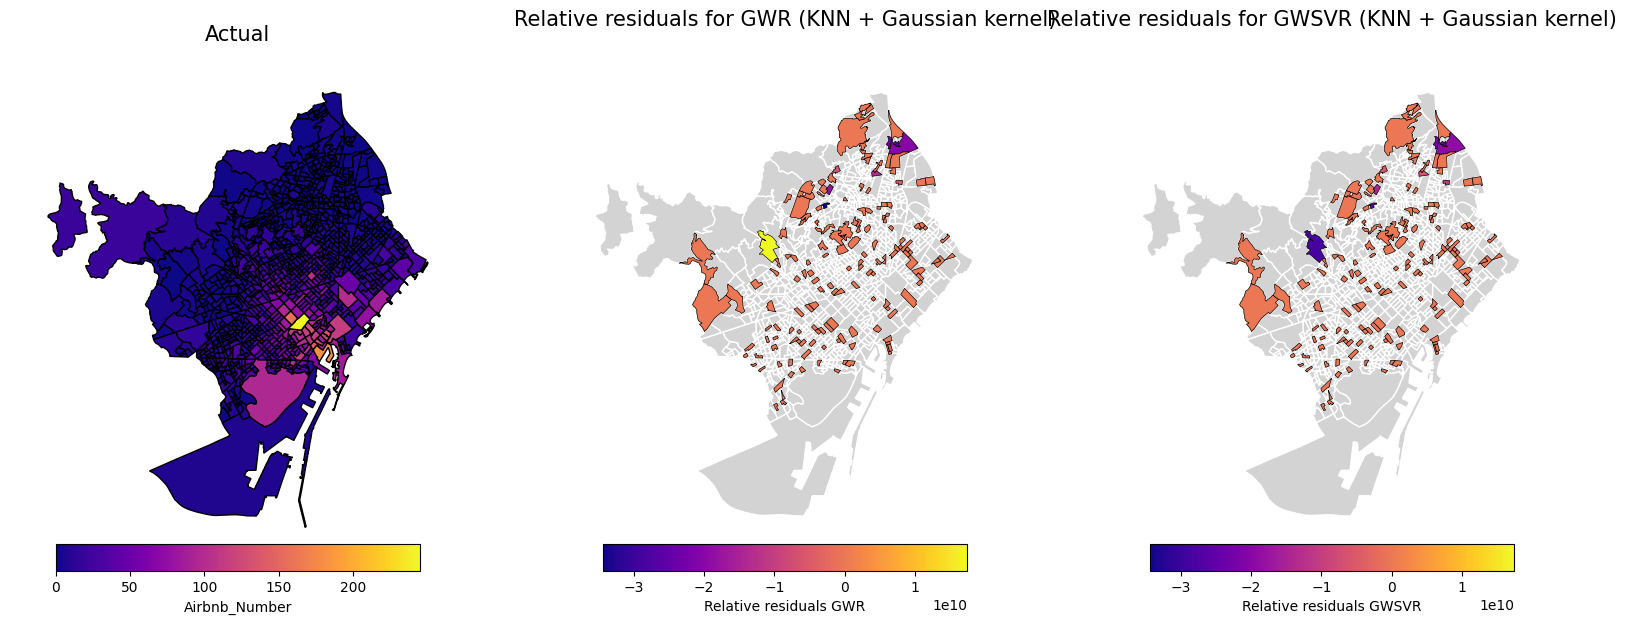

In [ ]:
# Plotting the relative residuals
is_test_gwr = geo_info['rel_residuals_GWR_k'].notna()
is_test_gwsvr = geo_info['rel_residuals_GWSVR_k'].notna()


fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# 1. Actual Airbnb Number
geo_info.plot(
    ax=ax[0],
    column='Airbnb_Number',
    cmap='plasma',
    edgecolor='black',
    legend=False
)
ax[0].set_title("Actual", fontsize=15)
ax[0].axis("off")

# Calculate common limits for relative residuals
res_min = min(geo_info['rel_residuals_GWR_k'].min(), geo_info['rel_residuals_GWSVR_k'].min())
res_max = max(geo_info['rel_residuals_GWR_k'].max(), geo_info['rel_residuals_GWSVR_k'].max())
xmin, xmax = geo_info.total_bounds[0], geo_info.total_bounds[2]
ymin, ymax = geo_info.total_bounds[1], geo_info.total_bounds[3]

# Zoom factor for all plots
zoom_factor = 0.1  # 10% extra margen
xrange = xmax - xmin
yrange = ymax - ymin
xmin_zoom = xmin - zoom_factor * xrange
xmax_zoom = xmax + zoom_factor * xrange
ymin_zoom = ymin - zoom_factor * yrange
ymax_zoom = ymax + zoom_factor * yrange

# 2. Relative residuals GWR (KNN + Gaussian kernel)
geo_info.plot(ax=ax[1], color='lightgrey', edgecolor='white')
geo_info[is_test_gwr].plot(
    column="rel_residuals_GWR_k",
    cmap="plasma",
    legend=False,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[1].set_title("Relative residuals for GWR (KNN + Gaussian kernel)", fontsize=15)
ax[1].axis("off")
ax[1].set_xlim(xmin_zoom, xmax_zoom)
ax[1].set_ylim(ymin_zoom, ymax_zoom)

# 3. Relative residuals GWSVR (KNN + Gaussian kernel)
geo_info.plot(ax=ax[2], color='lightgrey', edgecolor='white')
geo_info[is_test_gwsvr].plot(
    column="rel_residuals_GWSVR_k",
    cmap="plasma",
    legend=False,
    ax=ax[2],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[2].set_title("Relative residuals for GWSVR (KNN + Gaussian kernel)", fontsize=15)
ax[2].axis("off")
ax[2].set_xlim(xmin_zoom, xmax_zoom)
ax[2].set_ylim(ymin_zoom, ymax_zoom)

# Set common limits for all plots
ax[0].set_xlim(xmin_zoom, xmax_zoom)
ax[0].set_ylim(ymin_zoom, ymax_zoom)

# Add colorbars for each plot
for i, (sm, vmin, vmax, label) in enumerate([
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=geo_info['Airbnb_Number'].min(), vmax=geo_info['Airbnb_Number'].max())), geo_info['Airbnb_Number'].min(), geo_info['Airbnb_Number'].max(), "Airbnb_Number"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Relative residuals GWR"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Relative residuals GWSVR"),
]):
    sm._A = []
    cax = inset_axes(ax[i], width="80%", height="5%", loc='lower center', borderpad=0)
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label(label)

plt.show()


# Comparacion kernels

In [ ]:
# Comparison of predictions from paper and k in a table
rows = []
'GWR_Pred_gaussian',  'GWSVR_Pred_gaussian'
'GWR_Pred_k_gaussian',  'GWSVR_Pred_k_gaussian'

row = {
    'Model': 'GWR',
    'MAE (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'MAE'],
    'MAE (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'MAE'],
    'MAE improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'MAE'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'MAE']) / metrics_df.loc['GWR_Pred_gaussian', 'MAE'] * 100,
    'RMSE (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'RMSE'],
    'RMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'RMSE'],
    'RMSE improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'RMSE'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'RMSE']) / metrics_df.loc['GWR_Pred_gaussian', 'RMSE'] * 100,
    'NMSE (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'NMSE'],
    'NMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'NMSE'],
    'NMSE improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'NMSE'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'NMSE']) / metrics_df.loc['GWR_Pred_gaussian', 'NMSE'] * 100,
    'REP (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'REP'],
    'REP (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'REP'],
    'REP improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'REP'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'REP']) / metrics_df.loc['GWR_Pred_gaussian', 'REP'] * 100,
    'R2 (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'R² Score'],
    'R2 (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'R² Score'],
    'R2 improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'R² Score'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'R² Score']) / metrics_df.loc['GWR_Pred_gaussian', 'R² Score'] * 100,
    'RMSE (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'RMSE'],
    'RMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'RMSE'],
    'RMSE improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'RMSE'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'RMSE']) / metrics_df.loc['GWR_Pred_gaussian', 'RMSE'] * 100,
    'Pearson (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'Pearson Correlation'],
    'Pearson (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'Pearson Correlation'],
    'Pearson improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'Pearson Correlation'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'Pearson Correlation']) / metrics_df.loc['GWR_Pred_gaussian', 'Pearson Correlation'] * 100,
    'SMAPE (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'SMAPE'],
    'SMAPE (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'SMAPE'],
    'SMAPE improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'SMAPE'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'SMAPE']) / metrics_df.loc['GWR_Pred_gaussian', 'SMAPE'] * 100,
    'Time (s) (Gaussian kernel)': metrics_df.loc['GWR_Pred_gaussian', 'Time (s)'],
    'Time (s) (Gaussian kernel + KNN)': metrics_df_k.loc['GWR_Pred_k_gaussian', 'Time (s)'],
    'Time improvement (%)': (metrics_df.loc['GWR_Pred_gaussian', 'Time (s)'] - metrics_df_k.loc['GWR_Pred_k_gaussian', 'Time (s)']) / metrics_df.loc['GWR_Pred_gaussian', 'Time (s)'] * 100
}
rows.append(row)

row = {
    'Model': 'GWSVR',
    'MAE (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'MAE'],
    'MAE (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'MAE'],
    'MAE improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'MAE'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'MAE']) / metrics_df.loc['GWSVR_Pred_gaussian', 'MAE'] * 100,
    'RMSE (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'],
    'RMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'RMSE'],
    'RMSE improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'RMSE']) / metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'] * 100,
    'NMSE (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'NMSE'],
    'NMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'NMSE'],
    'NMSE improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'NMSE'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'NMSE']) / metrics_df.loc['GWSVR_Pred_gaussian', 'NMSE'] * 100,
    'REP (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'REP'],
    'REP (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'REP'],
    'REP improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'REP'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'REP']) / metrics_df.loc['GWSVR_Pred_gaussian', 'REP'] * 100,
    'R2 (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'R² Score'],
    'R2 (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'R² Score'],
    'R2 improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'R² Score'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'R² Score']) / metrics_df.loc['GWSVR_Pred_gaussian', 'R² Score'] * 100,
    'RMSE (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'],
    'RMSE (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'RMSE'],
    'RMSE improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'RMSE']) / metrics_df.loc['GWSVR_Pred_gaussian', 'RMSE'] * 100,
    'Pearson (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'Pearson Correlation'],
    'Pearson (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'Pearson Correlation'],
    'Pearson improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'Pearson Correlation'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'Pearson Correlation']) / metrics_df.loc['GWSVR_Pred_gaussian', 'Pearson Correlation'] * 100,
    'SMAPE (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'SMAPE'],
    'SMAPE (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'SMAPE'],
    'SMAPE improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'SMAPE'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'SMAPE']) / metrics_df.loc['GWSVR_Pred_gaussian', 'SMAPE'] * 100,
    'Time (s) (Gaussian kernel)': metrics_df.loc['GWSVR_Pred_gaussian', 'Time (s)'],
    'Time (s) (Gaussian kernel + KNN)': metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'Time (s)'],
    'Time improvement (%)': (metrics_df.loc['GWSVR_Pred_gaussian', 'Time (s)'] - metrics_df_k.loc['GWSVR_Pred_k_gaussian', 'Time (s)']) / metrics_df.loc['GWSVR_Pred_gaussian', 'Time (s)'] * 100
}
rows.append(row)

df_comparison = pd.DataFrame(rows)
# Display the comparison DataFrame
display(df_comparison.round(2).T)


0        1
Model                                 GWR    GWSVR
MAE (Gaussian kernel)                4.75     5.51
MAE (Gaussian kernel + KNN)          4.67     5.24
MAE improvement (%)                   1.7      4.9
RMSE (Gaussian kernel)               7.91     9.44
RMSE (Gaussian kernel + KNN)         7.76     9.22
RMSE improvement (%)                 1.82     2.28
NMSE (Gaussian kernel)               0.16     0.23
NMSE (Gaussian kernel + KNN)         0.16     0.22
NMSE improvement (%)                 3.61      4.5
REP (Gaussian kernel)                0.33     0.38
REP (Gaussian kernel + KNN)          0.32     0.36
REP improvement (%)                   1.7      4.9
R2 (Gaussian kernel)                 0.84     0.77
R2 (Gaussian kernel + KNN)           0.84     0.78
R2 improvement (%)                   -0.7    -1.36
Pearson (Gaussian kernel)            0.92      0.9
Pearson (Gaussian kernel + KNN)      0.92     0.89
Pearson improvement (%)             -0.22     0.86
SMAPE (Gaussian kernel)              0.56     0.57
SMAPE (Gaussian kernel + KNN)        0.58     0.55
SMAPE improvement (%)               -3.26     3.57
Time (s) (Gaussian kernel)         222.86   1920.9
Time (s) (Gaussian kernel + KNN)  1065.96  1929.31
Time improvement (%)              -378.31    -0.44

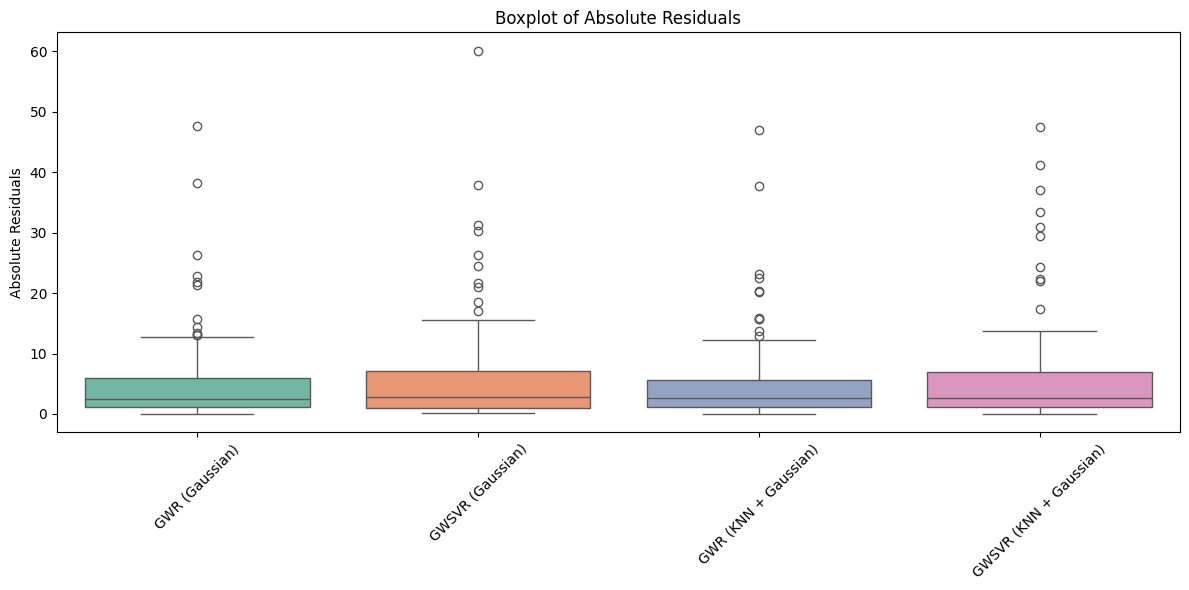

In [ ]:
# Boxplot of residuals
boxplot_residuals = pd.DataFrame({
    'GWR (Gaussian)': np.abs(y_test - y_pred_gwr_paper_locv),
    'GWSVR (Gaussian)': np.abs(y_test - y_pred_gwsvr_paper),
    'GWR (KNN + Gaussian)': np.abs(y_test - y_pred_gwr_k_locv),
    'GWSVR (KNN + Gaussian)': np.abs(y_test - y_pred_gwsvr_k)
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_residuals, palette="Set2")
plt.title("Boxplot of Absolute Residuals")
plt.ylabel("Absolute Residuals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

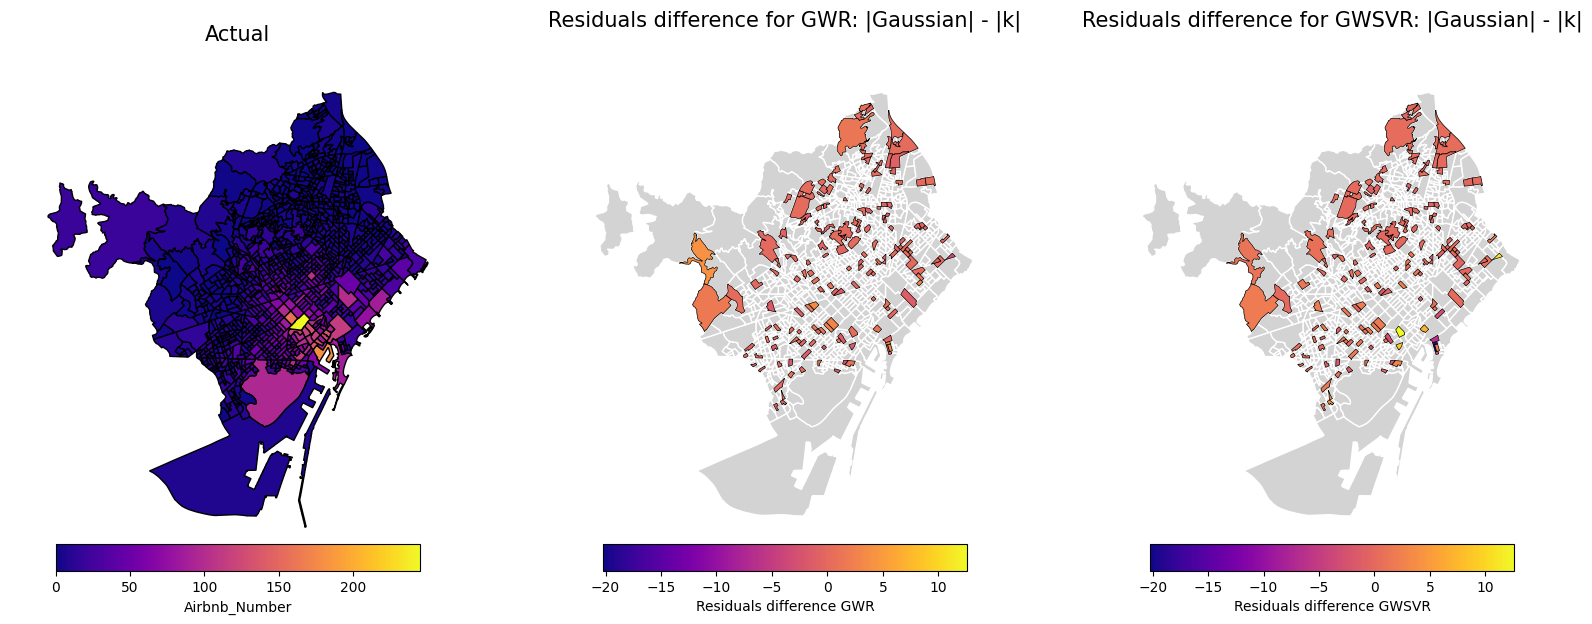

In [ ]:
# Plot differences of residuals between paper and k on the map
geo_info['residuals_diff_GWR'] = np.nan
geo_info['residuals_diff_GWSVR'] = np.nan
geo_info.loc[test_data.index, 'residuals_diff_GWR'] = geo_info.loc[test_data.index, 'abs_residuals_GWR'] - geo_info.loc[test_data.index, 'abs_residuals_GWR_k']
geo_info.loc[test_data.index, 'residuals_diff_GWSVR'] = geo_info.loc[test_data.index, 'abs_residuals_GWSVR'] - geo_info.loc[test_data.index, 'abs_residuals_GWSVR_k']

# Improve the plot of residual and actual value maps with horizontal colorbars below and more separated
is_test_gwr = geo_info['residuals_diff_GWR'].notna()
is_test_gwsvr = geo_info['residuals_diff_GWSVR'].notna()


fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# 1. Map of actual values
geo_info.plot(
    ax=ax[0],
    column='Airbnb_Number',
    cmap='plasma',
    edgecolor='black',
    legend=False
)
ax[0].set_title("Actual", fontsize=15)
ax[0].axis("off")

# Calculate common vmin and vmax for absolute residuals
res_min = min(geo_info['residuals_diff_GWR'].min(), geo_info['residuals_diff_GWSVR'].min())
res_max = max(geo_info['residuals_diff_GWR'].max(), geo_info['residuals_diff_GWSVR'].max())
xmin, xmax = geo_info.total_bounds[0], geo_info.total_bounds[2]
ymin, ymax = geo_info.total_bounds[1], geo_info.total_bounds[3]

# Get common spatial bounds (bounding box) and expand for less zoom
zoom_factor = 0.1  # 10% extra margin
xrange = xmax - xmin
yrange = ymax - ymin
xmin_zoom = xmin - zoom_factor * xrange
xmax_zoom = xmax + zoom_factor * xrange
ymin_zoom = ymin - zoom_factor * yrange
ymax_zoom = ymax + zoom_factor * yrange

# 2. Absolute residuals GWR
geo_info.plot(ax=ax[1], color='lightgrey', edgecolor='white')
geo_info[is_test_gwr].plot(
    column="residuals_diff_GWR",
    cmap="plasma",
    legend=False,
    ax=ax[1],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[1].set_title("Residuals difference for GWR: |Gaussian| - |k|", fontsize=15)
ax[1].axis("off")
ax[1].set_xlim(xmin_zoom, xmax_zoom)
ax[1].set_ylim(ymin_zoom, ymax_zoom)

# 3. Absolute residuals GWSVR
geo_info.plot(ax=ax[2], color='lightgrey', edgecolor='white')
geo_info[is_test_gwsvr].plot(
    column="residuals_diff_GWSVR",
    cmap="plasma",
    legend=False,
    ax=ax[2],
    edgecolor='black',
    linewidth=0.5,
    vmin=res_min,
    vmax=res_max,
    missing_kwds={"color": "none"},
)
ax[2].set_title("Residuals difference for GWSVR: |Gaussian| - |k|", fontsize=15)
ax[2].axis("off")
ax[2].set_xlim(xmin_zoom, xmax_zoom)
ax[2].set_ylim(ymin_zoom, ymax_zoom)

# Ensure the same zoom in the first plot as well
ax[0].set_xlim(xmin_zoom, xmax_zoom)
ax[0].set_ylim(ymin_zoom, ymax_zoom)

# Add horizontal colorbars below and more separated (lower the colorbar a bit)
for i, (sm, vmin, vmax, label) in enumerate([
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=geo_info['Airbnb_Number'].min(), vmax=geo_info['Airbnb_Number'].max())), geo_info['Airbnb_Number'].min(), geo_info['Airbnb_Number'].max(), "Airbnb_Number"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Residuals difference GWR"),
    (plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=res_min, vmax=res_max)), res_min, res_max, "Residuals difference GWSVR"),
]):
    sm._A = []
    cax = inset_axes(ax[i], width="80%", height="5%", loc='lower center', borderpad=0)
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label(label)

plt.show()


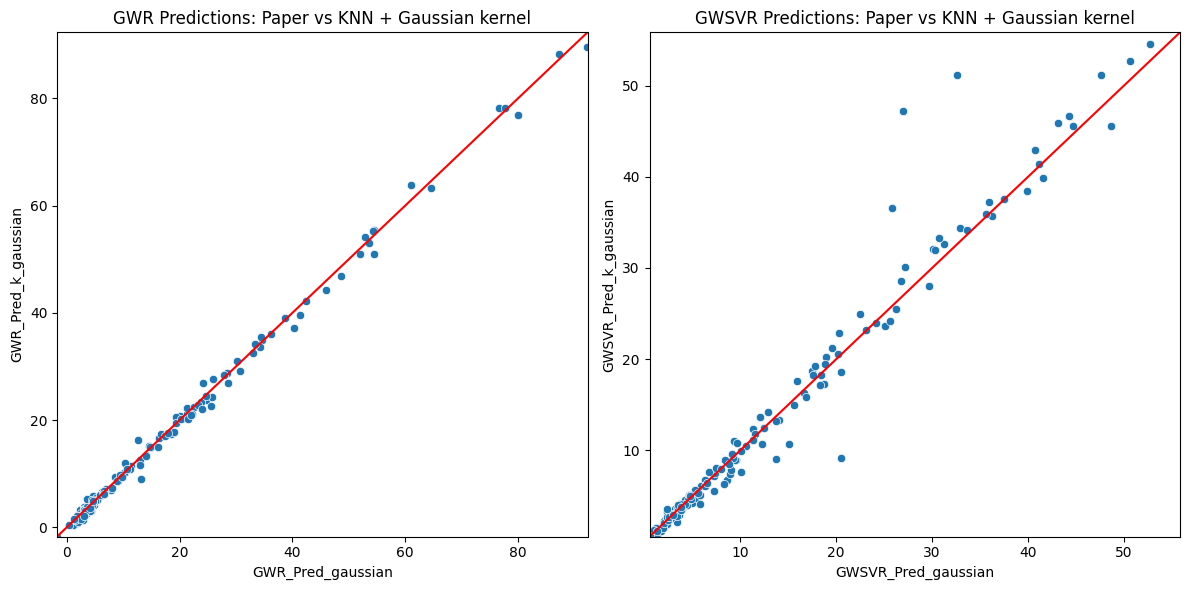

In [ ]:
# Plotting the predictions from the paper and KNN + Gaussian kernel side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=results_df['GWR_Pred_gaussian'], y=results_df_k['GWR_Pred_k_gaussian'])
plt.plot([results_df['GWR_Pred_gaussian'].min(), results_df['GWR_Pred_gaussian'].max()],
         [results_df['GWR_Pred_gaussian'].min(), results_df['GWR_Pred_gaussian'].max()], color='red')
plt.xlim(results_df['GWR_Pred_gaussian'].min(), results_df['GWR_Pred_gaussian'].max())
plt.ylim(results_df['GWR_Pred_gaussian'].min(), results_df['GWR_Pred_gaussian'].max())
plt.title("GWR Predictions: Paper vs KNN + Gaussian kernel")
plt.subplot(1, 2, 2)
sns.scatterplot(x=results_df['GWSVR_Pred_gaussian'], y=results_df_k['GWSVR_Pred_k_gaussian'])
plt.plot([results_df['GWSVR_Pred_gaussian'].min(), results_df['GWSVR_Pred_gaussian'].max()],
         [results_df['GWSVR_Pred_gaussian'].min(), results_df['GWSVR_Pred_gaussian'].max()], color='red')
plt.xlim(results_df['GWSVR_Pred_gaussian'].min(), results_df['GWSVR_Pred_gaussian'].max())
plt.ylim(results_df['GWSVR_Pred_gaussian'].min(), results_df['GWSVR_Pred_gaussian'].max())
plt.title("GWSVR Predictions: Paper vs KNN + Gaussian kernel")
plt.tight_layout()
plt.show()
